# Import Statements

In [1]:
import sys
import re
import random
from pathlib import Path
from typing import Dict, Tuple, Any, Optional, List, Callable, TypedDict, Iterator, DefaultDict
from collections import defaultdict
from itertools import combinations

import torch
import numpy as np
import numpy.typing as npt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as  lr_scheduler
import torchvision.models as models # pyright: ignore[reportMissingTypeStubs]
import torchvision.transforms as transforms # pyright: ignore[reportMissingTypeStubs]
from torchvision.models import get_model_weights # pyright: ignore[reportUnknownVariableType, reportMissingTypeStubs]
from torch.amp.grad_scaler import GradScaler
from torch.amp.autocast_mode import autocast
from torch.utils.data import Dataset, DataLoader, Sampler
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split # pyright: ignore[reportUnknownVariableType]
from sklearn.metrics import roc_curve, roc_auc_score # pyright: ignore[reportUnknownVariableType]

from PIL import Image

# Seeding

In [2]:
def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  # pyright: ignore[reportUnknownMemberType]
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
def seed_worker(worker_id: int) -> None:
    work_seed = 42 + worker_id
    np.random.seed(work_seed)
    random.seed(work_seed)

# Configurations

## Defining Custom Types 

In [4]:
class SchedulerEntry(TypedDict):
    name: str
    params: Dict[str, Any]

class SchedulerConfig(TypedDict, total=False):
    SCHEDULER: str
    MILESTONES: List[int]
    SCHEDULERS: List[SchedulerEntry]

class ModelState(TypedDict):
    epoch: int
    model_state_dict: Any
    optimiser_state_dict: Any
    scheduler_state_dict: Any
    auc: float
    best_loss: float
    patience_counter: int

## Dataset Path

In [5]:
DATASET_PATH: Dict[str, str] = {
    "CEDAR": "data\\CEDAR"
}

## Hyperparameters

In [6]:
LEARNING_CONFIG: Dict[str, str | int | float] = {
    "BATCH_SIZE": 32,
    "EPOCH": 50,
    "LEARNING_RATE": 1e-3,
    "EARLY_STOPPING_PATIENT": 10,
    
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu",
    
    "CHECKPOINT_DIR": "checkpoint/exp_01_mod_dummy",
    "LOG_DIR": "runs/exp_01_mod_dummy"
}

OPTIMISER_PARAMS: Dict[str, str | float] = {
    "optimiser": "AdamW",
    # Prevent overwriting the pretrained weights too aggressively
    "weight_decay": 1e-3,
}

# Linear Warmup and Cosine Decay
SCHEDULER_PARAMS: SchedulerConfig = {
    "SCHEDULER": "SequentialLR", 
    "MILESTONES": [5],
    "SCHEDULERS": [
        {
            "name": "LinearLR",
            "params": {
                "start_factor": 0.1,
                "total_iters": 5
            }
        },
        {
            "name": "CosineAnnealingLR",
            "params": {
                "T_max": int(LEARNING_CONFIG["EPOCH"])-5, 
                "eta_min": 1e-6
            }
        }
    ],
}

BACKBONE_CONFIG: Dict[str, Dict[str, Any]] = {
    "efficientnet_v2_s": {"builder": models.efficientnet_v2_s, "out_channels": 1280},
    "efficientnet_v2_m": {"builder": models.efficientnet_v2_m, "out_channels": 1280},
    "efficientnet_v2_l": {"builder": models.efficientnet_v2_l, "out_channels": 1280},
}

IMAGE_FORMATS: List[str] = [".png", ".jpg", ".jpeg", ".bmp"]

# Classes

## Model
The model uses `efficientnet`
```python
# use_extra_layers: bool = True,
# extra_channels: Optional[List[int]] = None,
```

In [7]:
class FeatureExtractionModel(nn.Module):
    def __init__(
        self,
        backbone_type: str,
        embedding_dim: int = 256,
        weights: Optional[str] = None, 
        dropout_rate: float  = 0.4,
    ) -> None:
        super().__init__()  # pyright: ignore[reportUnknownMemberType]
        self._check_parameters(backbone_type, embedding_dim, dropout_rate)
        
        FREEZE_UP_TO: int = 4
        
        self.embedding_dim = embedding_dim
        self.backbone_type = backbone_type
        self.dropout_rate = dropout_rate  
        
        self.weights = weights
        self.weights_enum = None
        
        backbone_builder = BACKBONE_CONFIG[self.backbone_type]["builder"]
        backbone_out_channels = BACKBONE_CONFIG[self.backbone_type]["out_channels"]
        
        self._retrieve_weights(str(self.weights), backbone_builder)
        
        self.model = backbone_builder(weights = self.weights_enum)
        
        first_layer = self.model.features[0][0]
        self.model.features[0][0] = nn.Conv2d(
            in_channels= 1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding,
            bias=first_layer.bias is not None,
        )
        
        if self.weights is not None:
            with torch.no_grad():
                self.model.features[0][0].weight.data = (
                    first_layer.weight.data.mean(dim=1, keepdim=True)
                )
        else:
            nn.init.kaiming_normal_(
                self.model.features[0][0].weight, mode="fan_out", nonlinearity="relu"
            )
            if self.model.features[0][0].bias is not None:
                nn.init.constant_(self.model.features[0][0].bias, 0)

        self.backbone = self.model.features

        # Zero shot Learning       
        # for param in self.backbone.parameters():
        #     param.requires_grad = False
        
        for i, block in enumerate(self.model.features):
            if i <= FREEZE_UP_TO:
                for param in block.parameters():
                    param.requires_grad = False
            else:
                for param in block.parameters():
                    param.requires_grad = True
            
        self.pool1 = nn.AdaptiveAvgPool2d(1) 
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(backbone_out_channels, 512)
        self.bn1 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(512, self.embedding_dim)
        self.bn2 = nn.BatchNorm1d(self.embedding_dim) 
        
        self.dropout = nn.Dropout(self.dropout_rate)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.backbone(x)
        
        x = self.pool1(x)
        x = self.flatten(x)
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        # x = self.relu(x)
        
        x = F.normalize(x, p=2, dim=1)
        
        return x
    
    def _check_parameters(
        self,
        backbone_type: str,
        embedding_dim: int,
        dropout_rate: float,
    ) -> None:
        if embedding_dim <= 0:
            raise ValueError(
                f"Embedding dimension must be positive, got {embedding_dim}"
            )
        if dropout_rate < 0 or dropout_rate > 1:
            raise ValueError(
                f"Dropout rate must be between 0 and 1, got {dropout_rate}"
            )
        if backbone_type not in BACKBONE_CONFIG:
            raise ValueError(
                f"Unsupported backbone type: {backbone_type}. Choose from {list(BACKBONE_CONFIG.keys())}"
            )
    
    def _retrieve_weights(
        self, 
        weights: str, 
        backbone_builder: Any
    ) -> None:
        try:
            weights_enum_type = get_model_weights(backbone_builder)
            if hasattr(weights_enum_type, weights):
                self.weights_enum = getattr(weights_enum_type, weights)
            else:
                print(
                    f"Warning: Could not get weights type for backbone '{self.backbone_type}'. Using default random initialisation.",
                    file=sys.stderr,
                )
                weights = ""
        except AttributeError:
            print(
                f"Warning: Specified weights alias '{weights}' not found for {self.backbone_type}. Check available weights in torchvision documentation. Using default random initialisation.",
                file=sys.stderr,
            )
            weights = ""
        except Exception as e:
            print(
                f"Warning: An unexpected error occurred looking up weights '{weights}' for {self.backbone_type}: {e}. Using default random initialisation.",
                file=sys.stderr,
            )
            
            weights = ""

## Loss Function
```python
        
pos_dist = torch.linalg.vector_norm(embeddings - positives, ord=self.p, dim=1) # pyright: ignore[reportUnknownVariableType, reportUnknownMemberType]
neg_dist = torch.linalg.vector_norm(embeddings - negatives, ord=self.p, dim=1) # pyright: ignore[reportUnknownVariableType, reportUnknownMemberType]

triplet_vals = pos_dist - neg_dist + self.margin # pyright: ignore[reportUnknownVariableType]
```        
        

In [8]:
class TripletLoss(nn.Module):
    def __init__(
        self, 
        margin: float = 1.0,
        mining_strategy: str = "batch_semi_hard",
        use_diversity: bool = False,
        lambda_diversity: float = 0.1,
        p: int = 2,
    ) -> None:
        super().__init__()  # pyright: ignore[reportUnknownMemberType]
        
        if margin < 0:
            raise ValueError(f"Margin must be non-negative, got {margin}")
        if mining_strategy not in ["batch_hard", "batch_semi_hard"]:
            raise ValueError(f"Invalid mining strategy, got {mining_strategy}")
        
        self.margin = margin
        self.mining_strategy = mining_strategy
        
        # optional, but it's usually not needed
        self.lambda_diversity = lambda_diversity
        self.use_diversity = use_diversity
        
        self.p = p
    
        # Calculate margin automatically
        self.base_loss = nn.TripletMarginLoss(margin=margin, p=p)
        
    def forward(
        self, 
        embeddings: torch.Tensor, 
        labels: torch.Tensor
    ) -> Tuple[torch.Tensor, Dict[str, Any]]:

        # compute pairwise distances
        distances = torch.cdist(embeddings, embeddings, p=self.p)
        mask_anchor_positive, mask_anchor_negative = self._get_triplet_mask(labels)
        
        if mask_anchor_positive.sum().item() == 0:
            print("No positive pairs in batch")
        
        if mask_anchor_negative.sum().item() == 0:
            print("No negative pairs in batch")

        if self.mining_strategy == "batch_hard":
            pos_idx, neg_idx = self._batch_hard_mining(distances, mask_anchor_positive, mask_anchor_negative)
        else:
            pos_idx, neg_idx, has_semi = self._batch_semi_hard_mining(distances, mask_anchor_positive, mask_anchor_negative)
        
            if not has_semi.any(): 
                print("No semi-hard negatives found (fallback to hard negatives)")

        # anchors = embeddings
        positives = embeddings[pos_idx]
        negatives = embeddings[neg_idx]
        
        batch_indices = torch.arange(distances.size(0), device=distances.device)
        pos_dist = distances[batch_indices, pos_idx]
        neg_dist = distances[batch_indices, neg_idx]

        triplet_vals = torch.stack([pos_dist, neg_dist], dim = 1)

        hn_ratio = (neg_dist < pos_dist).float().mean() if pos_dist.numel() else torch.tensor(0.0)  # pyright: ignore[reportUnknownVariableType, reportUnknownMemberType]
        
        stats: Dict[str, Any] = {
            "pos": pos_dist.detach(), 
            "neg": neg_dist.detach(),
            "triplet_vals": triplet_vals.detach(),
            "hn_ratio": hn_ratio.item(),
            "pos_idx": pos_idx.detach(),
            "neg_idx": neg_idx.detach(),
        }
        
        triplet_loss = self.base_loss(embeddings, positives, negatives)

        if self.use_diversity and self.lambda_diversity > 0:
            triplet_loss = triplet_loss + self._compute_diversity_regularisation(embeddings)

        return triplet_loss, stats

    # Gives me 1s and 0s
    def _get_triplet_mask(
        self, 
        labels: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        labels = labels.unsqueeze(1)
        mask_anchor_positive = (labels == labels.T) & ~torch.eye(
            labels.size(0), dtype=torch.bool, device=labels.device
        )
        mask_anchor_negative = labels != labels.T
        
        return (mask_anchor_positive, mask_anchor_negative)
    
    def _batch_hard_mining(
        self,
        distances: torch.Tensor,
        mask_anchor_positive: torch.Tensor,
        mask_anchor_negative: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        
        positive_distance = torch.where(
            mask_anchor_positive, distances, torch.full_like(distances, -float("inf"))
        )
        
        _max_positive_distance, pos_idx = torch.max(positive_distance, dim=1)
        
        negative_distance = torch.where(
            mask_anchor_negative, distances, torch.full_like(distances, float("inf"))
        )
        _min_negative_distance, neg_idx = torch.min(negative_distance, dim=1)
        
        return pos_idx, neg_idx

    def _batch_semi_hard_mining(
        self,
        distances: torch.Tensor,
        mask_anchor_positive: torch.Tensor,
        mask_anchor_negative: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        positive_distance_filtered = torch.where(
            mask_anchor_positive, distances, torch.full_like(distances, -float("inf"))
        )
        hardest_positive_dist, pos_idx = torch.max(positive_distance_filtered, dim=1)
        
        valid_negative_distances = torch.where(
            mask_anchor_negative, distances, torch.full_like(distances, float("inf"))
        )
        
        is_harder_than_positive = valid_negative_distances > hardest_positive_dist.unsqueeze(1)
        
        is_easier_than_margin = valid_negative_distances < (
            hardest_positive_dist.unsqueeze(1) + self.margin
        )
        
        semi_hard_mask = mask_anchor_negative & is_harder_than_positive & is_easier_than_margin

        semi_hard_negatives = torch.where(
            semi_hard_mask, distances, torch.full_like(distances, float("inf"))
        )
        
        _easiest_semi_hard, semi_idx = torch.min(semi_hard_negatives, dim=1)
        _hardest_overall, hard_idx = torch.min(valid_negative_distances, dim=1)

        use_semi = semi_hard_mask.sum(dim=1) > 0
        neg_idx = torch.where(use_semi, semi_idx, hard_idx)
        
        return pos_idx, neg_idx, use_semi
    
    # This is not really necessary
    def _compute_diversity_regularisation(self, embeddings: torch.Tensor) -> torch.Tensor:
        sim = embeddings @ embeddings.T
        eye = torch.eye(sim.size(0), device=sim.device, dtype=sim.dtype)
        diversity = (sim - eye).pow(2).mean()
        return self.lambda_diversity * diversity

### SCT+
```python
print(f'loss:{loss.item():.3f} hn_rt:{hn_ratio.item():.3f}', end='\r')
```

In [9]:
# class SCTLoss(nn.Module):
#     def __init__(
#         self, 
#         method: str, 
#         lam: float=1.0, 
#         margin: float = 1.0,
#         positive_pull_weight: float = 0.5,
#         verbose: bool = False,
#         hard_positive: bool = True,
#     ):
#         super(SCTLoss, self).__init__() # pyright: ignore[reportUnknownMemberType]
#         if method == 'sct':
#             self.sct, self.semi = True, False
#         elif method == 'hn':
#             self.sct, self.semi = False, False
#         elif method == 'shn':
#             self.sct, self.semi = False, True
#         else: raise ValueError('loss type is not supported')
        
#         self.lam = lam
#         self.margin = margin
#         self.verbose = verbose
#         self.positive_pull_weight = positive_pull_weight
#         self.hard_positive = hard_positive

#     def forward(
#         self,
#         fvec: torch.Tensor,
#         Lvec: torch.Tensor,
#     ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        
#         # Already normalised in the model
#         # fvec_norm: torch.Tensor = F.normalize(fvec, p = 2, dim = 1)
       
#         device = fvec.device
#         Same, Diff = self._build_boolean_masks(Lvec.view(-1))
#         CosSim = self._calculate_cosine_similarity(fvec, fvec)
        
#         Pos, I_pos, Mask_pos_valid, _Pos_log = self._select_positives(CosSim, Diff)
#         Neg, I_neg, Mask_neg_valid, _Neg_log = self._select_negatives(CosSim, Same, Diff, Pos)

#         Triplet_val, Triplet_idx, HardMask, EasyMask, hn_ratio = self._build_triplets(
#             Pos, Neg, I_pos, I_neg, Mask_pos_valid, Mask_neg_valid
#         )
        
#         loss = self._compute_loss(Triplet_val, Pos, Neg, HardMask, EasyMask, device)

#         if self.verbose:
#             hr = float(hn_ratio) if isinstance(hn_ratio, (float, int)) or (hasattr(hn_ratio, "item") and not torch.isnan(hn_ratio)) else 0.0
#             print(f'loss:{loss.item():.4f} hn_rt:{hr:.4f}', end='\r')
        
#         return (
#             loss, 
#             Triplet_val.clone().detach().cpu(), 
#             Triplet_idx.clone().detach().cpu(), 
#             hn_ratio if isinstance(hn_ratio, float) else hn_ratio.clone().detach().cpu(),
#             Pos.detach().cpu(), 
#             Neg.detach().cpu()
#         )
        
#     def _select_positives(
#         self, 
#         CosSim: torch.Tensor, 
#         Diff: torch.Tensor
#     ) -> Tuple[
#             torch.Tensor, 
#             torch.Tensor, 
#             torch.Tensor,
#             torch.Tensor,
#         ]:
        
#         # Select Easy Positive
#         D_easy = CosSim.clone().detach()
#         D_easy[Diff] = -1
#         V_easy, I_easy = D_easy.max(1)
#         mask_easy = (V_easy > -1) & (V_easy < 1)
        
#         # Select Hard Positives
#         D_hard = CosSim.clone().detach()
#         D_hard[Diff] = 2
#         V_hard, I_hard = D_hard.min(1)
#         mask_hard = (V_hard > -1) & (V_hard < 1)
         
#         if self.hard_positive and mask_hard.any():
#             Pos = CosSim[torch.arange(0, CosSim.size(0)), I_hard]
#             return Pos, I_hard, mask_hard, Pos.clone().detach().cpu()
        
#         Pos = CosSim[torch.arange(0, CosSim.size(0)), I_easy]
#         Pos_log = Pos.clone().detach().cpu()
    
#         return Pos, I_easy, mask_easy, Pos_log
    
#     def _select_negatives(
#         self, 
#         CosSim: torch.Tensor,
#         Same: torch.Tensor,
#         Diff: torch.Tensor, 
#         V_pos: torch.Tensor
#     ) -> Tuple[
#             torch.Tensor, 
#             torch.Tensor, 
#             torch.Tensor,
#             torch.Tensor,
#         ]:
        
#         D_neg = CosSim.clone().detach()
#         D_neg[Same] = -1
        
#         # Masking out non-Semi-Hard Negative
#         if self.semi:    
#             D_neg[(D_neg > V_pos.unsqueeze(1)) & Diff] = -1 
#             # D_neg[(D_neg > (V_pos.repeat(CosSim.size(0), 1).t())) & Diff] = -1
            
#         V_neg, I_neg = D_neg.max(1)
#         Mask_neg_valid = (V_neg > -1) & (V_neg < 1)
#         Neg = CosSim[torch.arange(0, CosSim.size(0)), I_neg]
#         Neg_log = Neg.clone().detach().cpu()
        
#         return Neg, I_neg, Mask_neg_valid, Neg_log 
        
#     def _build_triplets(
#         self, 
#         Pos: torch.Tensor, 
#         Neg: torch.Tensor,
#         I_pos: torch.Tensor,
#         I_neg: torch.Tensor,
#         Mask_pos_valid: torch.Tensor,
#         Mask_neg_valid: torch.Tensor
#     ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        
#         Mask_valid = Mask_pos_valid & Mask_neg_valid
#         HardMask = ((Neg > Pos) | (Neg > 0.8)) & Mask_valid
#         EasyMask = ((Neg < Pos) & (Neg < 0.8)) & Mask_valid
#         hn_ratio = (Neg>Pos)[Mask_valid].clone().float().mean().cpu()
        
#         Triplet_val = torch.stack([Pos, Neg], 1)
#         Triplet_idx = torch.stack([I_pos, I_neg], 1)
        
#         return Triplet_val, Triplet_idx, HardMask, EasyMask, hn_ratio
    
#         # Triplet_val_log = Triplet_val.clone().detach().cpu()
#         # Triplet_idx_log = Triplet_idx.clone().detach().cpu()
        
#     def _compute_loss(
#         self, 
#         Triplet_val: torch.Tensor, 
#         Pos: torch.Tensor, 
#         Neg: torch.Tensor,
#         HardMask: torch.Tensor, 
#         EasyMask: torch.Tensor,
#         device: torch.device,
#     ) -> torch.Tensor:
#         if self.sct:    
#             loss_hard = Neg[HardMask]
#             if loss_hard.numel() > 0:
#                 loss_hard = loss_hard.sum()
#             else:
#                 loss_hard = Triplet_val.sum() * 0.0
#                 # loss_hard = torch.zeros((), device=device, dtype=Triplet_val.dtype)
#                 print('No hard triplets in the batch')
            
#             easy_valid = Triplet_val[EasyMask, :]
#             if easy_valid.numel() > 0:
#                 loss_easy = -F.log_softmax(easy_valid / 0.1, dim=1)[:, 0].sum()
#             else:
#                 loss_easy = Triplet_val.sum() * 0.0
#                 # loss_easy = torch.zeros((), device=device, dtype=Triplet_val.dtype)
#                 print('No easy triplets in the batch')
            
#             pos_valid = (Pos > -1) & ( Pos < 1)
#             if pos_valid.any():
#                 positive_pull_valid = F.relu(self.margin - Pos[pos_valid])
#                 positive_pull = positive_pull_valid.mean()
#             else:
#                 positive_pull = Triplet_val.sum() * 0.0
#                 # positive_pull = torch.zeros((), device=device, dtype=Triplet_val.dtype)
                
#             N_hard = HardMask.float().sum().item()
#             N_easy = EasyMask.float().sum().item()
#             N_total = max(N_hard + N_easy, 1)
            
#             sct_loss = (loss_easy + self.lam * loss_hard) / N_total
            
#             return sct_loss + (self.positive_pull_weight * positive_pull)  
#         else:
#             return -F.log_softmax(Triplet_val / 0.1, dim=1)[:, 0].mean()

#     def _calculate_cosine_similarity(
#         self,     
#         Mat_A: torch.Tensor, 
#         Mat_B: torch.Tensor, 
#         norm:int=1, 
#     ) -> torch.Tensor: 
        
#         Mat_A = F.normalize(Mat_A, p=2, dim=1)
#         Mat_B = F.normalize(Mat_B, p=2, dim=1)
#         D = Mat_A.mm(torch.t(Mat_B))
    
#         # Ignore self-similarity
#         D.fill_diagonal_(-norm)
#         return D
    
#     def _build_boolean_masks(
#         self, 
#         Lvec: torch.Tensor
#     ) -> Tuple[torch.Tensor, torch.Tensor]:
#         Same = Lvec.unsqueeze(0) == Lvec.unsqueeze(1)
#         return Same.clone().fill_diagonal_(0), ~Same
    
#         # N = Lvec.size(0)
#         # Forms N x N
#         # Mask = Lvec.repeat(N,1)
        
#         # True if labels match
#         # Same = Lvec.unsqueeze(0) == Lvec.unsqueeze(1)
#         # Same = (Mask == Mask.t())
        
#         # Same / Different masks
#         # return Same.clone().fill_diagonal_(0), ~Same

In [10]:
class SCTLoss(nn.Module):
    def __init__(
        self, 
        method: str, 
        lam: float=1.0, 
        margin: float = 1.0,
        positive_pull_weight: float = 0.5,
        verbose: bool = False,
    ):
        super(SCTLoss, self).__init__() # pyright: ignore[reportUnknownMemberType]
        if method == 'sct':
            self.sct, self.semi = True, False
        elif method == 'hn':
            self.sct, self.semi = False, False
        elif method == 'shn':
            self.sct, self.semi = False, True
        else: raise ValueError('loss type is not supported')
        self.lam = lam
        self.margin = margin
        self.verbose = verbose
        self.positive_pull_weight = positive_pull_weight

    def forward(
        self,
        fvec: torch.Tensor,
        Lvec: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        
        # Already normalised in the model
        # fvec_norm: torch.Tensor = F.normalize(fvec, p = 2, dim = 1)
       
        device = fvec.device
        Same, Diff = self._build_boolean_masks(Lvec.view(-1))
        CosSim = self._calculate_cosine_similarity(fvec, fvec)
        
        Pos, I_pos, Mask_pos_valid, _Pos_log = self._select_positives(CosSim, Diff)
        Neg, I_neg, Mask_neg_valid, _Neg_log = self._select_negatives(CosSim, Same, Diff, Pos)

        Triplet_val, Triplet_idx, HardMask, EasyMask, hn_ratio = self._build_triplets(
            Pos, Neg, I_pos, I_neg, Mask_pos_valid, Mask_neg_valid
        )
        
        loss = self._compute_loss(Triplet_val, Pos, Neg, HardMask, EasyMask, device)

        if self.verbose:
            hr = float(hn_ratio) if isinstance(hn_ratio, (float, int)) or (hasattr(hn_ratio, "item") and not torch.isnan(hn_ratio)) else 0.0
            print(f'loss:{loss.item():.4f} hn_rt:{hr:.4f}', end='\r')
        
        return (
            loss, 
            Triplet_val.clone().detach().cpu(), 
            Triplet_idx.clone().detach().cpu(), 
            hn_ratio if isinstance(hn_ratio, float) else hn_ratio.clone().detach().cpu(),
            Pos.detach().cpu(), 
            Neg.detach().cpu()
        )
        
    def _select_positives(
        self, 
        CosSim: torch.Tensor, 
        Diff: torch.Tensor
    ) -> Tuple[
            torch.Tensor, 
            torch.Tensor, 
            torch.Tensor,
            torch.Tensor,
        ]:
        
        D_pos = CosSim.clone().detach()
        D_pos[Diff] = -1
        V_pos, I_pos = D_pos.max(1)

        # Select hard positives
        Mask_pos_valid = (V_pos > -1) & (V_pos < 1)        
        Pos = CosSim[torch.arange(0, CosSim.size(0)), I_pos]
        Pos_log = Pos.clone().detach().cpu()
    
        return Pos, I_pos, Mask_pos_valid, Pos_log
    
    def _select_negatives(
        self, 
        CosSim: torch.Tensor,
        Same: torch.Tensor,
        Diff: torch.Tensor, 
        V_pos: torch.Tensor
    ) -> Tuple[
            torch.Tensor, 
            torch.Tensor, 
            torch.Tensor,
            torch.Tensor,
        ]:
        
        D_neg = CosSim.clone().detach()
        D_neg[Same] = -1
        
        # Masking out non-Semi-Hard Negative
        if self.semi:    
            D_neg[(D_neg > V_pos.unsqueeze(1)) & Diff] = -1 
            # D_neg[(D_neg > (V_pos.repeat(CosSim.size(0), 1).t())) & Diff] = -1
            
        V_neg, I_neg = D_neg.max(1)
        Mask_neg_valid = (V_neg > -1) & (V_neg < 1)
        Neg = CosSim[torch.arange(0, CosSim.size(0)), I_neg]
        Neg_log = Neg.clone().detach().cpu()
        
        return Neg, I_neg, Mask_neg_valid, Neg_log 
        
    def _build_triplets(
        self, 
        Pos: torch.Tensor, 
        Neg: torch.Tensor,
        I_pos: torch.Tensor,
        I_neg: torch.Tensor,
        Mask_pos_valid: torch.Tensor,
        Mask_neg_valid: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        
        Mask_valid = Mask_pos_valid & Mask_neg_valid
        HardMask = ((Neg > Pos) | (Neg > 0.8)) & Mask_valid
        EasyMask = ((Neg < Pos) & (Neg < 0.8)) & Mask_valid
        hn_ratio = (Neg>Pos)[Mask_valid].clone().float().mean().cpu()
        
        Triplet_val = torch.stack([Pos, Neg], 1)
        Triplet_idx = torch.stack([I_pos, I_neg], 1)
        
        return Triplet_val, Triplet_idx, HardMask, EasyMask, hn_ratio
    
        # Triplet_val_log = Triplet_val.clone().detach().cpu()
        # Triplet_idx_log = Triplet_idx.clone().detach().cpu()
        
    def _compute_loss(
        self, 
        Triplet_val: torch.Tensor, 
        Pos: torch.Tensor, 
        Neg: torch.Tensor,
        HardMask: torch.Tensor, 
        EasyMask: torch.Tensor,
        device: torch.device,
    ) -> torch.Tensor:
        if self.sct:    
            loss_hard = Neg[HardMask].sum()
            N_hard = HardMask.float().sum().item()
            if torch.isnan(loss_hard) or N_hard == 0:
                loss_hard, N_hard = torch.tensor(0.0), 0
                print('No hard triplets in the batch')
                
            loss_easy = -F.log_softmax(
                Triplet_val[EasyMask, :] / 0.1, dim=1
            )[:, 0].sum()
            N_easy = EasyMask.float().sum().item()
            if torch.isnan(loss_easy) or N_easy == 0:
                loss_easy, N_easy = torch.tensor(0.0), 0
                print('No easy triplets in the batch')
            
            pos_valid = (Pos > -1) & ( Pos < 1)
            if pos_valid.any():
                positive_pull = F.relu(self.margin - Pos[pos_valid]).mean()
            else:
                positive_pull = torch.tensor(0.0, device=device, requires_grad=True)

            N_total = max(N_hard + N_easy, 1)
            sct_loss = (loss_easy + self.lam * loss_hard) / N_total
            
            return sct_loss + (self.positive_pull_weight * positive_pull)  
            # return (loss_easy + self.lam * loss_hard) / N_total
        else:
            return -F.log_softmax(Triplet_val / 0.1, dim=1)[:, 0].mean()

            # return -F.log_softmax(
            #     Triplet_val[Triplet_val, :] / 0.1, dim=1
            # )[:, 0].mean()

    def _calculate_cosine_similarity(
        self,     
        Mat_A: torch.Tensor, 
        Mat_B: torch.Tensor, 
        norm:int=1, 
    ) -> torch.Tensor: 
        
        Mat_A = F.normalize(Mat_A, p=2, dim=1)
        Mat_B = F.normalize(Mat_B, p=2, dim=1)
        # _N_A = Mat_A.size(0)
        # _N_B = Mat_B.size(0)
    
        D = Mat_A.mm(torch.t(Mat_B))
    
        # Ignore self-similarity
        D.fill_diagonal_(-norm)
        return D
    
    def _build_boolean_masks(
        self, 
        Lvec: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        # N = Lvec.size(0)
        # Forms N x N
        # Mask = Lvec.repeat(N,1)
        
        # True if labels match
        Same = Lvec.unsqueeze(0) == Lvec.unsqueeze(1)
        # Same = (Mask == Mask.t())
        
        # Same / Different masks
        return Same.clone().fill_diagonal_(0), ~Same

In [11]:
class SCTLossWrapper(nn.Module):
    def __init__(
        self, 
        method: str = "sct", 
        lam: float = 1.0,
        margin: float = 1.0,
        positive_pull_weight: float = 0.5,
        verbose: bool = False
    ) -> None:
        super().__init__() # pyright: ignore[reportUnknownMemberType]
        self.loss_fn = SCTLoss(method, lam, margin, positive_pull_weight, verbose)

    def forward(
        self, 
        fvec: torch.Tensor, 
        Lvec: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        
        # SCTLoss returns (loss, Triplet_val.clone().detach().cpu(), Triplet_idx.clone().detach().cpu(), hn_ratio, Pos, Neg)
        return self.loss_fn(fvec, Lvec)

## Dataset

In [12]:
class PKSampler(Sampler[List[int]]):
    def __init__(
        self,
        label_to_indices: Dict[str, List[int]],  # now full labels, e.g., "10_orig", "10_forg"
        P: int,  # signers per batch
        K: int,  # originals per signer
        F: int,  # forgeries per signer
        M: int,  # inter-signer negatives per signer
        seed: int = 42,
    ):
        """
        label_to_indices: Dict[label_string, List[idx]]
            e.g., {"10_orig": [0,1,2], "10_forg": [25,26], "11_orig": [...], ...}
        """
        self.P = P
        self.K = K
        self.F = F
        self.M = M
        self.label_to_indices = label_to_indices
        self.signers = sorted({lbl.split("_")[0] for lbl in label_to_indices.keys()})
        self.seed = seed

        # Precompute label-wise pools
        self._all_indices: List[int] = []
        self._indices_by_label: Dict[str, List[int]] = {}
        self._indices_by_signer: Dict[str, List[int]] = defaultdict(list)
        
        for label, idxs in label_to_indices.items():
            self._indices_by_label[label] = idxs
            signer_id = label.split("_")[0]
            self._indices_by_signer[signer_id].extend(idxs)
            self._all_indices.extend(idxs)

    def __len__(self) -> int:
        return max(1, len(self.signers) // self.P * 10)

    def __iter__(self) -> Iterator[List[int]]:
        rng = random.Random(self.seed)
        num_batches = len(self)
        for _ in range(num_batches):
            selected_signers = rng.sample(self.signers, self.P)
            batch: List[int] = []

            for sid in selected_signers:
                orig_label = f"{sid}_orig"
                forg_label = f"{sid}_forg"

                originals = self._indices_by_label.get(orig_label, [])
                forgeries = self._indices_by_label.get(forg_label, [])

                # Sample K originals (anchor + positives)
                pos = rng.sample(originals, self.K) if len(originals) >= self.K else rng.choices(originals, k=self.K)

                # Sample F intra-signer forgeries as hard negatives
                neg_hard = rng.sample(forgeries, self.F) if len(forgeries) >= self.F else rng.choices(forgeries, k=self.F)

                # Sample M inter-signer negatives (any label from other signers)
                global_pool = [idx for idx in self._all_indices if idx not in self._indices_by_signer[sid]]
                neg_global = rng.sample(global_pool, self.M) if len(global_pool) >= self.M else rng.choices(global_pool, k=self.M)

                batch.extend(pos + neg_hard + neg_global)

            yield batch


In [13]:
class SignatureDataset(Dataset[Tuple[torch.Tensor, str]]):
    def __init__(
        self, 
        data_map: Dict[str, Dict[str, List[str]]],
        transform: Optional[Callable[[Image.Image], torch.Tensor]] = None,
    ) -> None:
        self.data_map = data_map
        self.transform = transform
        self.signer_ids = sorted(list(data_map.keys()), key=int)
        
        # signer id, image type, index
        self.all_image_references: List[Tuple[str, str, int]] = []
        # self.labels: List[int] = []
        
        for signer_id in self.signer_ids:
            for index, _ in enumerate(data_map[signer_id].get("original", [])):
                self.all_image_references.append((signer_id, "original", index))
            
            for index, _ in enumerate(data_map[signer_id].get("forged", [])):
                self.all_image_references.append((signer_id, "forged", index))
        
        
        self.labels = [
            f"{signer_id}_{img_type[:4]}"  # "orig" or "forg"
            for signer_id, img_type, _ in self.all_image_references
        ]
        

    def __len__(self)->int:
        return len(self.all_image_references)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, str]:
        signer_id, image_type, image_index = self.all_image_references[index]
                
        path: str = self.data_map[signer_id][image_type][image_index]
        
        image_pil: Image.Image = Image.open(path).convert("L")
            
        if self.transform is not None:
            image_tensor: torch.Tensor = self.transform(image_pil)
        else:
            image_array: npt.NDArray[np.uint8] = np.array(image_pil, dtype=np.uint8)
            image_tensor: torch.Tensor = torch.from_numpy(image_array).unsqueeze(0).float() / 255.0 # type: ignore
        
        label = f"{signer_id}_{image_type[:4]}"
        
        # signer_label_tensor = torch.tensor(int(signer_id), dtype=torch.long)
        
        return image_tensor, label
        # return image_tensor, signer_label_tensor

In [14]:
class TestSignatureDataset(Dataset[Tuple[torch.Tensor, str]]):
    """
    Produces samples in the exact order expected by build_verification_pairs():
        sorted signer IDs → originals → forgeries
    """

    def __init__(
        self,
        data_map: Dict[str, Dict[str, List[str]]],
        transform: Optional[Callable[[Image.Image], torch.Tensor]] = None,
    ) -> None:
        self.data_map = data_map
        self.transform = transform

        # Ensure deterministic ordering
        self.signer_ids = sorted(list(data_map.keys()), key=int)

        # Build ordered list matching evaluation logic
        self.ordered_items: List[Tuple[str, str, str]] = []
        # (signer_id, "original"/"forged", path)

        for sid in self.signer_ids:
            for path in data_map[sid].get("original", []):
                self.ordered_items.append((sid, "original", path))

            for path in data_map[sid].get("forged", []):
                self.ordered_items.append((sid, "forged", path))

    def __len__(self) -> int:
        return len(self.ordered_items)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, str]:
        signer_id, _img_type, path = self.ordered_items[index]

        image_pil = Image.open(path).convert("L")

        if self.transform is not None:
            image_tensor: torch.Tensor = self.transform(image_pil)
        else:
            image_array: npt.NDArray[np.uint8] = np.array(image_pil, dtype=np.uint8)
            image_tensor: torch.Tensor = torch.from_numpy(image_array).unsqueeze(0).float() / 255.0 # pyright: ignore[reportUnknownMemberType]
        
        # IMPORTANT:
        # evaluation code expects label to be a *tensor containing string IDs*
        # but torch can't store strings → so evaluation uses batching with collate_fn default
        # Each label is kept as a Python string.
        return image_tensor, signer_id

## Training

In [15]:
class Trainer:
    def __init__(
        self, 
        model: nn.Module,
        loss_function: nn.Module,
        learning_config: Dict[str, str | int | float],
        optimiser_config: Dict[str, str | float],
        scheduler_config: SchedulerConfig,
        save_checkpoints: bool = True
    ) -> None:
        
        self.model = model
        
        # Training loop
        self.epoch = int(learning_config["EPOCH"])
        self.batch_size = int(learning_config["BATCH_SIZE"])
        self.lr = float(learning_config["LEARNING_RATE"])
        self.early_stop = int(learning_config["EARLY_STOPPING_PATIENT"])
        self.checkpoint_path = Path(str(learning_config["CHECKPOINT_DIR"]))
        self.save_checkpoints = bool(save_checkpoints)
        self.device = torch.device(str(learning_config["DEVICE"]))
        self.device_type = self.device.type
        self.global_step = 0
        
        self.best_val_auc = float("inf")
        self.patience_counter = 0
        
        # Optimiser
        self.optimiser = self._build_optimiser(optimiser_config)
        
        # Scheduler
        self.scheduler = self._build_scheduler(scheduler_config)

        # Loss function
        self.loss_function = loss_function
        
        # Mixed precision
        self.scaler = GradScaler()
        
        # Moving to GPU
        self.model.to(self.device)
        
        # checkpointing
        self.checkpoint_path.mkdir(parents=True, exist_ok=True)
        
        # Tensorboard
        log_dir = learning_config["LOG_DIR"]
        self.writer = SummaryWriter(log_dir)
        
    def train_epoch(
        self, dataloader: DataLoader[Tuple[torch.Tensor, str]]
    ) -> float:
        self.model.train()
        running_loss: float = 0.0
        num_batches: int = len(dataloader)
        
        for batch_index, (images, labels) in enumerate(dataloader):
            images = images.to(self.device)
            unique_labels = sorted(set(labels))
            label_to_int = {label: i for i, label in enumerate(unique_labels)}
            label_tensor = torch.tensor([label_to_int[label] for label in labels], dtype=torch.long, device=self.device)
        
            self.optimiser.zero_grad()
            
            with autocast(device_type=self.device_type):
                outputs = self.model(images)
                
                # SCTLoss returns (loss, triplet_vals, triplet_idxs, hn_ratio, Pos_log, Neg_log)
                loss, triplet_vals, _triplet_idxs, hn_ratio, pos, neg= self.loss_function(outputs, label_tensor)
                
                # Vanilla Triplet Loss returns (loss, stats)
                # loss, stats = self.loss_function(outputs, label_tensor)
            
            # Gradient clipping is optional
            
            self.scaler.scale(loss).backward()  # pyright: ignore[reportUnknownMemberType]
            self.scaler.step(self.optimiser)
            self.scaler.update()
            
            # OneCycleLR steps for batch, not epoch
            if isinstance(self.scheduler, lr_scheduler.OneCycleLR):
                self.scheduler.step()

            running_loss += loss.item()
            self.global_step += 1
            
            if batch_index % 19 == 0:
                # For both SCT and vanilla Triplet Loss
                self.writer.add_scalar(f"Train/BatchLoss", loss.item(), self.global_step) # pyright: ignore[reportUnknownMemberType]
                
                # # SCT
                self.writer.add_scalar(f"Train/HN_Ratio", hn_ratio.item(), self.global_step) # pyright: ignore[reportUnknownMemberType]
                self.writer.add_scalar(f"Train/PosMean", pos.mean().item(), self.global_step) # pyright: ignore[reportUnknownMemberType]
                self.writer.add_scalar(f"Train/NegMean", neg.mean().item(), self.global_step) # pyright: ignore[reportUnknownMemberType]
                
                self.writer.add_histogram(f"Train/Pos", triplet_vals[:,0], self.global_step) # pyright: ignore[reportUnknownMemberType]
                self.writer.add_histogram(f"Train/Neg", triplet_vals[:,1], self.global_step) # pyright: ignore[reportUnknownMemberType]
                
                # Vanilla Triplet Loss
                # self.writer.add_scalar("Train/HN_Ratio", stats["hn_ratio"], self.global_step) # pyright: ignore[reportUnknownMemberType]
                # self.writer.add_scalar("Train/PosMean", stats["pos"].mean().item(), self.global_step) # pyright: ignore[reportUnknownMemberType]
                # self.writer.add_scalar("Train/NegMean", stats["neg"].mean().item(), self.global_step) # pyright: ignore[reportUnknownMemberType]

                # self.writer.add_histogram("Train/Pos", stats["triplet_vals"][:,0], self.global_step) # pyright: ignore[reportUnknownMemberType]
                # self.writer.add_histogram("Train/Neg", stats["triplet_vals"][:,1], self.global_step) # pyright: ignore[reportUnknownMemberType]
                
                total_norm: float = 0.
                for p in self.model.parameters():
                    if p.grad is not None:
                        total_norm += float(p.grad.data.norm(2).item()) # pyright: ignore[reportUnknownArgumentType, reportUnknownMemberType]
                        
                self.writer.add_scalar("Gradients/TotalNorm", total_norm, self.global_step) # pyright: ignore[reportUnknownMemberType]
        
        return running_loss / num_batches
        
    def evaluate(
        self,
        dataloader: DataLoader[Tuple[torch.Tensor, str]] 
    ) -> Tuple[
            Dict[str, float], 
            torch.Tensor, 
            List[str]
    ]:
        self.model.eval()
        all_embeddings_list: List[torch.Tensor] = []
        all_labels: List[str] = []
        
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(self.device)
                
                with autocast(device_type=self.device_type):
                    embeddings = self.model(images)
                    all_embeddings_list.append(embeddings.cpu())
                    all_labels.extend(labels)
        
        all_embeddings = torch.cat(all_embeddings_list, dim=0)
        n = len(all_labels)
        
        similarity_matrix = F.cosine_similarity(
            all_embeddings.unsqueeze(1),
            all_embeddings.unsqueeze(0),
            dim=2
        )
        
        signer_ids = [label.split("_")[0] for label in all_labels]
        intra_mask = torch.zeros((n, n), dtype=torch.bool)
        inter_mask = torch.zeros((n, n), dtype=torch.bool)
        
        for i in range(n):
            for j in range(n):
                if i == j:
                    continue
                if signer_ids[i] == signer_ids[j]:
                    intra_mask[i, j] = True
                else:
                    inter_mask[i, j] = True

        intra_sims: torch.Tensor = similarity_matrix[intra_mask] 
        inter_sims: torch.Tensor = similarity_matrix[inter_mask]  

        intra_sims_np = intra_sims.cpu().numpy() # type: ignore
        inter_sims_np = inter_sims.cpu().numpy() # type: ignore

        # Metrics
        y_true = [1] * len(intra_sims_np) + [0] * len(inter_sims_np) # type: ignore
        y_scores = list(intra_sims_np) + list(inter_sims_np) # type: ignore
        auc = roc_auc_score(y_true, y_scores)

        metrics: Dict[str, float | int] = {
            "AUC": auc, # type: ignore
            "mean_intra_similarity": float(intra_sims.mean()),
            "mean_inter_similarity": float(inter_sims.mean()),
            "num_intra_pairs": len(intra_sims),
            "num_inter_pairs": len(inter_sims)
        }

        return metrics, all_embeddings, all_labels
    
    def fit(
        self, 
        train_dataloader: DataLoader[Tuple[torch.Tensor, str]],
        val_dataloader: DataLoader[Tuple[torch.Tensor, str]]
    ) -> None: 
        for epoch in range(self.epoch):
            train_loss = self.train_epoch(train_dataloader)
            val_metrics, val_embedding, all_labels = self.evaluate(val_dataloader)
            
            self.writer.add_embedding( # pyright: ignore[reportUnknownMemberType]
                mat = val_embedding,
                metadata=all_labels,
                global_step=self.global_step
            )
            
            self.writer.add_scalar("Loss/train", train_loss, epoch) # pyright: ignore[reportUnknownMemberType]
            self.writer.add_scalar("AUC/val", val_metrics["AUC"], epoch) # pyright: ignore[reportUnknownMemberType]
            # I should change this to include loss value from validation too
            self.writer.add_scalar("Loss/1_minus_auc", 1.0 - val_metrics["AUC"], epoch) # pyright: ignore[reportUnknownMemberType] 
            self.writer.add_scalar("Learning rate", self.optimiser.param_groups[0]["lr"], epoch) # pyright: ignore[reportUnknownMemberType]
            
            if self.scheduler is not None and not isinstance(self.scheduler, lr_scheduler.OneCycleLR):
                self.scheduler.step()

            print(f"Epoch [{epoch + 1}/{self.epoch}]"
                  f"| Train loss: {train_loss:.4f}"
                  f"| AUC: {val_metrics["AUC"]:.4f}")
        
            val_auc_for_stop = 1.0 - val_metrics["AUC"]
            if val_auc_for_stop < self.best_val_auc:
                self.best_val_auc = val_auc_for_stop
                self.patience_counter = 0
                if self.save_checkpoints:
                    self._save_checkpoint(epoch, val_auc_for_stop, self.best_val_auc, self.patience_counter)
            else:
                self.patience_counter+=1
                if self.patience_counter >= self.early_stop:
                    print("Early stopping")
                    break
        
        self.writer.close()
    
    def load_checkpoint(
        self, 
        path: str
    ) -> None:
        
        self._has_path(path)
        try:
            checkpoint_model: ModelState = torch.load(path, map_location=self.device)
        except Exception as e:
            raise RuntimeError(f"Error loading checkpoint from {path}: {e}")
        
        self.model.load_state_dict(checkpoint_model["model_state_dict"])
        self.optimiser.load_state_dict(checkpoint_model["optimiser_state_dict"])
        
        if self.scheduler and checkpoint_model["scheduler_state_dict"] is not None:
            self.scheduler.load_state_dict(checkpoint_model["scheduler_state_dict"])
        
        self.epoch = checkpoint_model["epoch"]
        self.best_val_auc = checkpoint_model["best_loss"]
        self.patience_counter = checkpoint_model["patience_counter"]
    
    def _save_checkpoint(
        self, 
        epoch: int, 
        auc: float, 
        best_auc: float, 
        patience_counter: int,
    ) -> None:
        model_state: ModelState = {
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimiser_state_dict": self.optimiser.state_dict(),
            "scheduler_state_dict": self.scheduler.state_dict() if self.scheduler else None,
            "auc": auc,
            "best_loss": best_auc,
            "patience_counter": patience_counter
        }
        
        torch.save(
            model_state, self.checkpoint_path / f"{epoch+1}_auc_{auc:.4f}.pt"
        )
    
    def _has_path(self, path: str) -> None:
        if not Path(path).exists():
            raise FileNotFoundError(f"File not found at {path}")
        print(f"File is ok!")
                
    def _build_optimiser(self, optimiser_config: Dict[str, str | float]) -> optim.Optimizer:
        optimiser_name =  str(optimiser_config["optimiser"])
        optimiser_class = getattr(optim, optimiser_name)
        
        optimiser_params = {**optimiser_config}
        optimiser_params.pop("optimiser")
        optimiser_params["lr"] = self.lr
        
        return optimiser_class(self.model.parameters(), **optimiser_params)
        
    def _build_scheduler(
        self, 
        scheduler_config: SchedulerConfig,
        ) -> Optional[lr_scheduler.LRScheduler]:
        schedulers: List[lr_scheduler.LRScheduler] = []
         
        for sched_cfg in scheduler_config.get("SCHEDULERS", []):
            name = sched_cfg["name"]
            params = sched_cfg.get("params", {})
            sched_class = getattr(lr_scheduler, name)
            schedulers.append(sched_class(self.optimiser, **params))

        if scheduler_config.get("SCHEDULER") == "SequentialLR":
            return lr_scheduler.SequentialLR(
                self.optimiser,
                schedulers=schedulers,
                milestones=scheduler_config.get("MILESTONES", [])
            )
        
        return schedulers[0] if schedulers else None

# Evaluation

In [16]:
def compute_metrics(
    pos_scores: List[float],
    neg_scores: List[float]
) -> Dict[str, Any]:
    
    metrics: Dict[str, Any] = {
        "AUC": float("nan"),
        "EER": float("nan"),
        "threshold": float("nan"),
        "fpr": np.array([]),
        "tpr": np.array([]),
    }
    
    if len(pos_scores) == 0 or len(neg_scores) == 0:
        return metrics
    
    y_true = [1] * len(pos_scores) + [0] * len(neg_scores)
    y_score = pos_scores + neg_scores
    
    try:
        auc = roc_auc_score(y_true, y_score)
    except Exception:
        metrics["AUC"] = float("nan")
        return metrics
    
    fpr, tpr, thresholds = roc_curve(y_true, y_score) # pyright: ignore[reportUnknownVariableType]

    fnr = 1 - tpr # pyright: ignore[reportUnknownVariableType]
    abs_diffs = np.abs(fnr - fpr) # pyright: ignore[reportUnusedVariable, reportUnknownArgumentType]
    eer_index = int(np.argmin(abs_diffs))
    
    eer = float((fnr[eer_index] + fpr[eer_index]) / 2.0)
    threshold = float(thresholds[eer_index])

    metrics.update({
        "AUC": float(auc),
        "EER": eer,
        "threshold": threshold,
        "fpr": fpr,
        "tpr": tpr,
        "thresholds":thresholds
    })
    
    return metrics

In [17]:
def compute_scores(
    embeddings: torch.Tensor,
    pairs: List[Tuple[int, int]]
) -> List[float]:
    scores: List[float] = []
    if len(pairs) == 0:
        return scores
    
    for i, j in pairs:
        if i < 0 or j < 0 or i >= embeddings.shape[0] or j >= embeddings.shape[0]:
            continue
        sim = F.cosine_similarity(
            embeddings[i].unsqueeze(0),
            embeddings[j].unsqueeze(0),
        ).item()
        scores.append(float(sim))
    return scores    

In [18]:
def build_verification_pairs(
    embeddings: torch.Tensor,
    test_map: Dict[str, Dict[str, List[str]]]
) -> Tuple[List[Tuple[int, int]], List[Tuple[int, int]], List[Tuple[int, int]]]: 
    num_samples = embeddings.shape[0]
    
    ordered_paths: List[Tuple[str, str, str]] = []
    # ordered_types = []
    
    for signer_id in sorted(test_map.keys(), key=int):
        for path in test_map[signer_id].get("original", []):
            ordered_paths.append((signer_id, "original", path))
    
        for path in test_map[signer_id].get("forged", []):
            ordered_paths.append((signer_id, "forged", path))
    
    assert len(ordered_paths) == num_samples, \
        "Embedding count does not match number of test images."
        
    # signer_to_indices = {}
    orig_indices: Dict[str, List[int]] = {}
    forg_indices: Dict[str, List[int]] = {}
    
    for index, (sid, t, _) in enumerate(ordered_paths):
        # signer_to_indices.setdefault(sid, []).append(index)
        if t == "original":
            orig_indices.setdefault(sid, []).append(index)
        else: forg_indices.setdefault(sid, []).append(index)
    
    pos_pairs: List[Tuple[int, int]] = []
    for sid, indices in orig_indices.items():
        if len(indices) >= 2:
            for i, j in combinations(indices, 2):
                pos_pairs.append((i, j))
    
    intra_neg_pairs: List[Tuple[int, int]] = []
    for sid in orig_indices.keys():
        o_idxs = orig_indices[sid]
        f_idxs = forg_indices.get(sid, [])
        for i in o_idxs:
            for j in f_idxs:
                intra_neg_pairs.append((i, j))
    
    inter_neg_pairs: List[Tuple[int, int]] = []
    sids = list(orig_indices.keys())  # original-only ensures consistency

    for sid_a, sid_b in combinations(sids, 2):
        for i in orig_indices[sid_a]:
            for j in orig_indices[sid_b]:
                inter_neg_pairs.append((i, j))
                
    return pos_pairs, intra_neg_pairs, inter_neg_pairs

In [19]:
def embed_all(
    model: nn.Module, 
    dataloader: DataLoader[Tuple[torch.Tensor, str]], 
    device: torch.device
) -> torch.Tensor:
    
    model.eval()
    embeddings_list: List[torch.Tensor] = []
    # labels_list: List[str] = []
    
    with torch.no_grad():
        for images, _signer_ids in dataloader:
            images = images.to(device)
            embedding = model(images)
            embeddings_list.append(embedding.cpu())
            # labels_list.append(signer_ids.cpu())
            
    all_embeddings = torch.cat(embeddings_list)
    # labels = torch.cat(labels_list)
    
    return all_embeddings

In [20]:
def summarize_operating_point(fpr: Any, tpr: Any, thresholds: Any, chosen_threshold: Any):
    # Find the index closest to your chosen threshold
    idx = (np.abs(thresholds - chosen_threshold)).argmin()
    return {
        "threshold": thresholds[idx],
        "TPR": tpr[idx],   # genuine acceptance rate
        "FPR": fpr[idx],   # forgery acceptance rate
    }

In [21]:
def compute_accuracy(pos_scores: List[float], neg_scores: List[float], threshold: float) -> float:
    if len(pos_scores) == 0 and len(neg_scores) == 0:
        return float("nan")
    
    # Genuine pairs should be above threshold
    pos_correct = sum([1 for s in pos_scores if s >= threshold])
    # Forgery pairs should be below threshold
    neg_correct = sum([1 for s in neg_scores if s < threshold])
    
    total = len(pos_scores) + len(neg_scores)
    correct = pos_correct + neg_correct
    
    return correct / total if total > 0 else float("nan")


In [22]:
def evaluate(
    model: nn.Module, 
    test_loader: DataLoader[Tuple[torch.Tensor, str]], 
    test_map:  Dict[str, Dict[str, List[str]]],
    device: torch.device
) -> Dict[str, Any]:
    model.to(device)
    
    # Applying the model
    embeddings = embed_all(model, test_loader, device)

    # original, easy, and hard forgery  
    pos_pairs, intra_pairs, inter_pairs = build_verification_pairs(embeddings, test_map)

    # Intra and Inter
    neg_pairs = intra_pairs + inter_pairs
    
    # Compute similarities
    pos_scores = compute_scores(embeddings, pos_pairs)
    neg_scores = compute_scores(embeddings, neg_pairs)

    # Metrics
    metrics = compute_metrics(pos_scores, neg_scores)
    op_point = summarize_operating_point(
        metrics["fpr"], metrics["tpr"], thresholds=metrics["thresholds"], chosen_threshold=metrics["threshold"]
    )
    accuracy = compute_accuracy(pos_scores, neg_scores, metrics["threshold"])
    metrics["accuracy"] = accuracy

    print(f"At threshold {op_point['threshold']:.3f}:")
    print(f"  TPR (genuine accepted) = {op_point['TPR']*100:.1f}%")
    print(f"  FPR (forgeries accepted) = {op_point['FPR']*100:.1f}%")

    return {
        # "embeddings": embeddings,
        "pos_scores": sum(pos_scores)/len(pos_scores),
        "neg_scores": sum(neg_scores)/len(neg_scores),
        "metrics": metrics,
    }

# Utility Functions

In [23]:
def extract_signer_id(file_name: str) -> str:
    match = re.search(r"(?:original|forgeries|forgery|forged)_(\d+)_", file_name)
    if match: return match.group(1) 
    return f"UNKNOWN_SIGNER"

In [24]:
def retrieve_signature_images(
    images_path: Path, 
) -> List[Tuple[str, str]]:
    
    signature_images: List[Tuple[str, str]] = []
    if not images_path.is_dir():
        print(f"Warning: Directory not found! {images_path}") 
        return []
    for image_path in images_path.iterdir():
        if image_path.is_file() and image_path.suffix.lower() in IMAGE_FORMATS:
            signer_id = extract_signer_id(str(image_path))
            if signer_id != "UNKNOWN_SIGNER":
                signature_images.append((signer_id, str(image_path)))
            else:
                print(
                    f"Warning: Could not extract signer ID from file: {image_path.name}"
                )
    return signature_images

In [25]:
def prepare_signature_map(
    original_signatures: List[Tuple[str, str]],
    forged_signatures: List[Tuple[str, str]],
) -> Dict[str, Dict[str, List[str]]]:
    
    signature_dictionary: defaultdict[str, Dict[str, List[Any]]] = defaultdict(
        lambda: {
            "original": [], 
            "forged": []
        }
    )
    
    for category, signatures in [("original", original_signatures),
                                 ("forged", forged_signatures)]:
        for signer_id, image_path in signatures:
            signature_dictionary[signer_id][category].append(image_path)
            
    return signature_dictionary

In [26]:
def training_and_testing_split(
    signature_dictionary: Dict[str, Dict[str, List[str]]],
    test_ratio: float = 0.2,
    val_ratio: float = 0.1,
    random_state: int = 42,
) -> Tuple[
        Dict[str, Dict[str, List[str]]], 
        Dict[str, Dict[str, List[str]]],
        Dict[str, Dict[str, List[str]]]
    ]:
    train_map: Dict[str, Dict[str, List[str]]] = {}
    val_map: Dict[str, Dict[str, List[str]]] = {}
    test_map: Dict[str, Dict[str, List[str]]] = {} 
    
    signer_ids: List[str] = sorted(list(signature_dictionary.keys()), key=int)
    
    strat_labels: List[int] = []
    for sid in signer_ids:
        originals = len(signature_dictionary[sid].get("original", []))
        forgeries = len(signature_dictionary[sid].get("forged", []))
        strat_labels.append(0 if originals >= forgeries else 1)

    train_val_ids, test_ids = train_test_split( # pyright: ignore[reportUnknownVariableType]
        signer_ids,
        test_size=test_ratio,
        random_state=random_state,
        stratify=strat_labels,
    )

    strat_labels_train_val = [
        strat_labels[signer_ids.index(sid)] for sid in train_val_ids  # type: ignore
    ]
    val_size = val_ratio / (1 - test_ratio)
    train_ids, val_ids = train_test_split( # pyright: ignore[reportUnknownVariableType]
        train_val_ids, # pyright: ignore[reportUnknownArgumentType]
        test_size=val_size,
        random_state=random_state,
        stratify=strat_labels_train_val,
    )

    train_map = {sid: signature_dictionary[sid] for sid in train_ids} # pyright: ignore[reportUnknownVariableType]
    val_map = {sid: signature_dictionary[sid] for sid in val_ids} # pyright: ignore[reportUnknownVariableType]
    test_map = {sid: signature_dictionary[sid] for sid in test_ids} # pyright: ignore[reportUnknownVariableType] 

    return train_map, val_map, test_map

In [27]:
def build_label_to_indices(dataset: SignatureDataset) -> dict[str, List[int]]:
    label_to_indices: DefaultDict[str, List[int]] = defaultdict(list)
    for index in range(len(dataset)):
        _, label = dataset[index]
        label_to_indices[label].append(index)
    
    return dict(label_to_indices)

In [28]:
def pretty_metrics(metrics: Dict[str, Any]) -> None:
    print("=== Evaluation Metrics ===")
    print(f"AUC       : {metrics['AUC']:.4f}")
    print(f"EER       : {metrics['EER']:.4f}")
    print(f"Threshold : {metrics['threshold']:.4f}")
    
    # Summarize ROC curve
    fpr = metrics['fpr']
    tpr = metrics['tpr']
    if len(fpr) > 0:
        print(f"ROC Points: {len(fpr)}")
        print(f"FPR range : {fpr.min():.4f} → {fpr.max():.4f}")
        print(f"TPR range : {tpr.min():.4f} → {tpr.max():.4f}")

# Driver Code

In [29]:
seed_everything(42)
g = torch.Generator()
g.manual_seed(42)

In [30]:
train_transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.RandomAffine(
            degrees=(-5, 5), 
            translate=(0.1, 0.1), 
            scale=(0.95, 1.05), 
            shear=(-5, 5)
        ),

        transforms.RandomResizedCrop(
            (384, 384), 
            scale=(0.9, 1.05), 
            ratio=(0.95, 1.05), 
            antialias=True
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5], std=[0.5]
    )])

test_transform = transforms.Compose([
        transforms.Resize((384, 384)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.5], std=[0.5]
    )])

In [31]:
dataset_path: Path = Path(DATASET_PATH["CEDAR"])
original_signatures = retrieve_signature_images(dataset_path / "original")
forged_signatures = retrieve_signature_images(dataset_path / "forged")

In [32]:
signature_map = prepare_signature_map(original_signatures, forged_signatures)

In [33]:
train_map, val_map, test_map = training_and_testing_split(
    signature_map, test_ratio=0.2, random_state=42
)

In [34]:
train_dataset = SignatureDataset(train_map, train_transform)
val_dataset = SignatureDataset(val_map, test_transform)

test_dataset = TestSignatureDataset(test_map, test_transform)
train_dataset_for_evaluation = TestSignatureDataset(train_map, test_transform)

In [35]:
label_to_indices = build_label_to_indices(train_dataset)
train_sampler = PKSampler(label_to_indices, 8, 2, 2, 2)

In [36]:
train_dataloader = DataLoader(
    train_dataset, 
    batch_sampler=train_sampler, 
    pin_memory=True, 
    worker_init_fn=seed_worker, 
    generator=g
)
val_dataloader = DataLoader(
    val_dataset, 
    int(LEARNING_CONFIG["BATCH_SIZE"]), 
    shuffle=False, 
    pin_memory=True, 
    worker_init_fn=seed_worker
)
test_dataloader = DataLoader(
    test_dataset,
    int(LEARNING_CONFIG["BATCH_SIZE"]),
    shuffle=False
)
train_dataloader_for_evaluation = DataLoader(
    train_dataset_for_evaluation,
    int(LEARNING_CONFIG["BATCH_SIZE"]),
    shuffle=False
)

In [37]:
model = FeatureExtractionModel("efficientnet_v2_m", 256, "IMAGENET1K_V1")

In [38]:
# loss_function = TripletLoss(0.5,"batch_semi_hard", use_diversity=False)
loss_function = SCTLossWrapper(method="sct", lam=1.0, margin=0.5, positive_pull_weight=0.5, verbose = True)

In [39]:
model_trainer = Trainer(
    model,
    loss_function,
    LEARNING_CONFIG,
    OPTIMISER_PARAMS,
    SCHEDULER_PARAMS,
    True
)

In [40]:
model_trainer.fit(train_dataloader, val_dataloader)

No easy triplets in the batch
No easy triplets in the batch


KeyboardInterrupt: 

In [ ]:
# model_trainer.load_checkpoint("checkpoint/exp_01_mod_sct/15_auc_0.0692.pt")

File is ok!


In [ ]:
result = evaluate(model, test_dataloader, test_map, torch.device("cuda"))
print(f"Accuracy: {(result["metrics"]["accuracy"])*100:.4f}%\n")
print("Positive and Negative Scores")
print(f"Positive Score: {result["pos_scores"]:.4f}\n"
      f"Negative Score: {result["neg_scores"]:.4f}\n")
pretty_metrics(result["metrics"])

At threshold 0.675:
  TPR (genuine accepted) = 88.9%
  FPR (forgeries accepted) = 11.1%
Accuracy: 88.8946%

Positive and Negative Scores
Positive Score: 0.8401
Negative Score: 0.2011

=== Evaluation Metrics ===
AUC       : 0.9568
EER       : 0.1112
Threshold : 0.6745
ROC Points: 3167
FPR range : 0.0000 → 1.0000
TPR range : 0.0000 → 1.0000


In [ ]:
result = evaluate(model, train_dataloader_for_evaluation, train_map, torch.device("cuda"))
print(f"Accuracy: {(result["metrics"]["accuracy"])*100:.4f}%\n")
print("Positive and Negative Scores")
print(f"Positive Score: {result["pos_scores"]:.4f}\n"
      f"Negative Score: {result["neg_scores"]:.4f}\n")
pretty_metrics(result["metrics"])

At threshold 0.720:
  TPR (genuine accepted) = 99.6%
  FPR (forgeries accepted) = 0.4%
Accuracy: 99.6225%

Positive and Negative Scores
Positive Score: 0.9748
Negative Score: 0.1145

=== Evaluation Metrics ===
AUC       : 0.9999
EER       : 0.0038
Threshold : 0.7205
ROC Points: 4811
FPR range : 0.0000 → 1.0000
TPR range : 0.0000 → 1.0000


In [ ]:
# model_trainer._save_checkpoint(24, 0.1051, 0.0692, 10)

# Because I just wanted to

In [ ]:
def calculate_metrics(
    reference_feature_embeddings: torch.Tensor, input_feature_embeddings: torch.Tensor
) -> Tuple[float, float, float, float, float]:
    similarity = F.cosine_similarity(
        reference_feature_embeddings, input_feature_embeddings
    ).item()

    distance = F.pairwise_distance(
        reference_feature_embeddings, input_feature_embeddings
    ).item()

    normalised_distance = max(0, min(1, distance / 1.3))
    distance_score = 1 - normalised_distance

    # Greater emphasis is placed on the distance calculated.
    confidence_score = 0.8 * similarity + 0.2 * distance_score

    return similarity, confidence_score, normalised_distance, distance_score, distance

In [ ]:
def apply_threshold(
    similarity: float, 
    distance: float,
    confidence_score: float,
    result: Dict[str, bool | float | str]
) -> None:
    pass_thresholds = (
        similarity >= 0.5 and 
        distance <= 1.07
    )
    
    if pass_thresholds:
        if confidence_score >= 0.9:
            result['prediction_level'] = 'Very High Confidence'
            result['is_genuine'] = True
        elif confidence_score >= 0.8:
            result['prediction_level'] = 'High Confidence'
            result['is_genuine'] = True
        elif confidence_score >= 0.7:
            result['prediction_level'] = 'Medium Confidence'
            result['is_genuine'] = True
        elif confidence_score >= 0.6:
            result['prediction_level'] = 'Low Confidence'
        else:
            result['prediction_level'] = "Very Low Confidence"
    else:
        result['prediction_level'] = 'Failed Threshold Check'
            

In [ ]:
def apply_model(
    reference_tensor: torch.Tensor,
    forged_same_signer_tensor: torch.Tensor,
) -> Tuple[torch.Tensor, torch.Tensor]:
    
    reference_feature_embeddings = torch.Tensor(model(reference_tensor))
    forged_same_signer_feature_embeddings = torch.Tensor(model(
        forged_same_signer_tensor
    ))
    return (
        reference_feature_embeddings,
        forged_same_signer_feature_embeddings,
    )

In [ ]:
for i in range(55):  # signer IDs
    for j in range(23):  # pick one original signature
        reference_signature_image_path = Path(
            f"data/CEDAR/original/original_{i+1}_{j+1}.png"
        )
        reference_image = Image.open(str(reference_signature_image_path)).convert("L")
        reference_tensor = test_transform(reference_image).unsqueeze(0).to("cuda") # pyright: ignore[reportUnknownVariableType, reportAttributeAccessIssue, reportUnknownMemberType]

        # Now compare this original against *all forgeries* of this signer
        for k in range(23):  
            forged_input_same_signer = Path(
                f"data/CEDAR/forged/forgeries_{i+1}_{k+1}.png"
            )
            forged_same_signer = Image.open(str(forged_input_same_signer)).convert("L")
            forged_tensor = test_transform(forged_same_signer).unsqueeze(0).to("cuda") # pyright: ignore[reportUnknownVariableType, reportAttributeAccessIssue, reportUnknownMemberType]

            ref_emb, forged_emb = apply_model(reference_tensor, forged_tensor) # pyright: ignore[reportUnknownArgumentType]
            similarity, confidence, norm_dist, dist_score, distance = calculate_metrics(ref_emb, forged_emb)

            result: Dict[str, Any] = {
                "is_genuine": False,
                "confidence_score": confidence,
                "similarity_score": similarity,
                "euclidean_distance": norm_dist,
                "distance_score": dist_score,
                "prediction_level": "unknown",
                "passed_thresholds": False,
            }
            apply_threshold(similarity, dist_score, confidence, result)
            print(f"Signer {i+1}, Original {j+1} vs Forgery {k+1} → {result}")

# Temporary

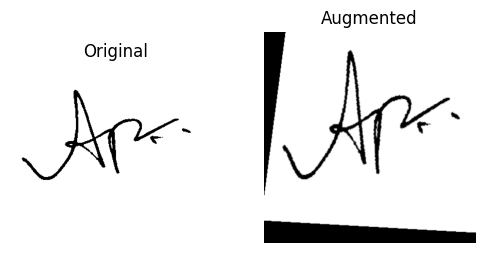

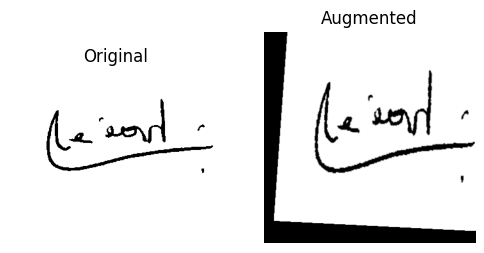

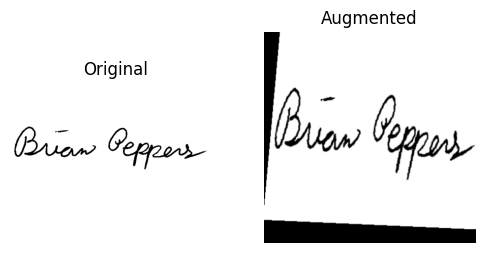

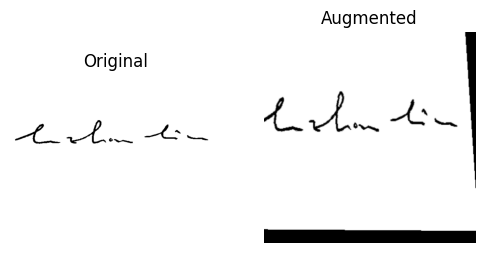

In [38]:
import os
import matplotlib.pyplot as plt

image_directory = "data/CEDAR/original/"
image_file = random.sample(os.listdir(image_directory), 4)

for filename in image_file:
    path = os.path.join(image_directory, filename)
    image = Image.open(path).convert("L") 
    aug_img = train_transform(image)
    aug_img_np = aug_img.squeeze().numpy()

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.title("Original")
    plt.imshow(image, cmap='gray')
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Augmented")
    plt.imshow(aug_img_np, cmap='gray')
    plt.axis("off")

# Dump

## Scheduling



### Hardcoding Scheduling (Reference)

```python
from torch.optim.lr_scheduler import CosineAnnealingLR, SequentialLR, LinearLR

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

warmup = LinearLR(optimizer, start_factor=0.1, total_iters=5)
cosine = CosineAnnealingLR(optimizer, T_max=50)

scheduler = SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[5])
```



### More Flexible

```python
if "WARMUP_SCHEDULER" in scheduler_config:
    warmup_name = str(scheduler_config["WARMUP_SCHEDULER"])
    warmup_class = getattr(lr_scheduler, warmup_name)
    warmup_scheduler = warmup_class(
        self.optimiser, 
        start_factor=scheduler_config["WARMUP_START_FACTOR"],
        total_iters=scheduler_config["WARMUP_EPOCHS"]
    )
    schedulers.append(warmup_scheduler)

if "MAIN_SCHEDULER" in scheduler_config:
    main_name = str(scheduler_config["MAIN_SCHEDULER"])
    main_class = getattr(lr_scheduler, main_name)
    main_scheduler = main_class(
        self.optimiser,
        T_max=scheduler_config["T_MAX"],
        eta_min=scheduler_config["eta_min"]
    )
    schedulers.append(main_scheduler)

if scheduler_config["SCHEDULER"] == "SequentialLR":
    scheduler_class = getattr(lr_scheduler, "SequentialLR")
    scheduler = scheduler_class(
        self.optimiser,
        schedulers=schedulers,
        milestones=scheduler_config["MILESTONES"]
    )
    return scheduler
```

## Config

### Model Related
```python 
"EMBEDDING_DIM": 256,
        
# Optional
"GRAD_CLIP": 1.0,
"K_FOLD": 5, 
```

### Scheduling
```python
"WARMUP_SCHEDULER": "LinearLR",
"WARMUP_EPOCHS": 2,
"WARMUP_START_FACTOR": 0.1,

"MAIN_SCHEDULER": "CosineAnnealingLR",
"T_MAX": int(LEARNING_CONFIG["EPOCH"]) - 2,
"eta_min": 1e-6,
```

### EvalResult
```python
This needs changing
@dataclass
class EvalResults:
    distances: npt.NDArray[np.float32]
    labels: npt.NDArray[np.int64]
    embeddings: Dict[str, npt.NDArray[np.float32]]
    metrics: Dict[str, npt.NDArray[np.float32]]
    curves: Dict[str, npt.NDArray[np.float32]] 
```

## Sampler

### PKSampler
Still does not different forgeries in originals
```python
class PKSampler(Sampler[List[int]]):
    def __init__(
        self,
        signer_to_indices: Dict[str, Dict[str, List[int]]], 
        P: int,          # signers per batch
        K: int,          # originals per signer
        F: int,          # forgeries per signer
        M: int,          # inter-signer global negatives PER signer in batch
        seed: int = 42
    ):
        """
        signer_to_indices:
            {
                signer_id: {
                    "original": [idx,...],
                    "forged":   [idx,...]
                }
            }
        """
        self.P = P
        self.K = K
        self.F = F
        self.M = M
        
        self.signer_to_indices = signer_to_indices
        self.signers = list(signer_to_indices.keys())
        self.seed = seed

        # Precompute global negatives
        self._all_indices = []
        self._indices_by_signer = {}
        for sid, groups in signer_to_indices.items():
            all_for_sid = groups["original"] + groups["forged"]
            self._indices_by_signer[sid] = set(all_for_sid)
            self._all_indices.extend(all_for_sid)

    def __len__(self):
        return max(1, len(self.signers) // self.P * 10)

    def __iter__(self):
        rng = random.Random(self.seed)

        while True:
            selected_signers = rng.sample(self.signers, self.P)
            batch = []

            for sid in selected_signers:
                originals = self.signer_to_indices[sid]["original"]
                forgeries = self.signer_to_indices[sid]["forged"]

                # Sample originals
                pos = rng.sample(originals, self.K) if len(originals) >= self.K else rng.choices(originals, k=self.K)

                # Sample forgeries
                neg_hard = rng.sample(forgeries, self.F) if len(forgeries) >= self.F else rng.choices(forgeries, k=self.F)

                # Sample inter-signer negatives
                # All indices EXCEPT this signer
                global_pool = [x for x in self._all_indices if x not in self._indices_by_signer[sid]]
                neg_global = rng.sample(global_pool, self.M)

                batch.extend(pos + neg_hard + neg_global)

            yield batch
```

### ForgeryAwarePKSampler

Still the same issue

```python
class ForgeryAwarePKSampler(Sampler[List[int]]):
    def __init__(
        self,
        signer_to_indices: Dict[str, Dict[str, List[int]]],
        P: int,
        K: int,
        seed: Optional[int] = 42
    )
        """
        signer_to_indices: {
            signer_id: {
                "original": [list of dataset indices],
                "forgery": [list of dataset indices]
            }
        }
        P: number of signers per batch
        K: number of originals per signer
        """
        self.P = P
        self.K = K
        self.signer_to_indices = signer_to_indices
        self.signers = list(signer_to_indices.keys())
        self.seed = seed

    def __iter__(self):
        rng = random.Random(self.seed)
        while True:
            selected_signers = rng.sample(self.signers, self.P)
            batch = []

            for signer in selected_signers:
                originals = self.signer_to_indices[signer]["original"]
                forgeries = self.signer_to_indices[signer]["forged"]

                # Sample K originals (positives)
                pos_samples = rng.sample(originals, self.K) if len(originals) >= self.K else rng.choices(originals, k=self.K)
                # Sample K forgeries (negatives)
                neg_samples = rng.sample(forgeries, self.K) if len(forgeries) >= self.K else rng.choices(forgeries, k=self.K)

                batch.extend(pos_samples + neg_samples)

            yield batch  # List[int] of indices

    def __len__(self):
        return max(1, len(self.signers) // self.P * 10)
```

### PKSampler
This sampler does not differentiate forgeries and originals of the same signer

```python
class PKSampler(Sampler[List[int]]):
    def __init__(
        self, 
        labels: List[int], 
        P: int, 
        K: int,
    ) -> None:
        
        self.labels = labels
        # Classes per batch
        self.P = P
        # Samples per class
        self.K = K
        self.label_to_indices: Dict[int, List[int]] = {}
        
        for idx, label in enumerate(labels):
            self.label_to_indices.setdefault(label, []).append(idx)
        
        self.labels_set = list(self.label_to_indices.keys())
        

    def __iter__(self) -> Iterator[List[int]]:
        for _ in range(len(self)):
            # Randomly select P classes from the available classes. 
            selected_labels = random.sample(self.labels_set, self.P)
            batch: List[int] = []
            for label in selected_labels:
                indices = self.label_to_indices[label]
                # Checks if the class has at least K samples
                if len(indices) >= self.K:
                    # Samples K indices without replacement
                    batch.extend(random.sample(indices, self.K))
                else:
                    # Samples K indices with replacement
                    batch.extend(random.choices(indices, k=self.K)) 
            yield batch

    def __len__(self) -> int:
        n = len(self.labels)
        if n == 0:
            return 0
        return max(1, n // (self.P * self.K))
    
        # return len(self.labels) // (self.P * self.K)
```

## Test Dataset

These two datasets are not well made for evaluation.

```python
class TestSignatureDataset(Dataset[Tuple[torch.Tensor, torch.Tensor, torch.Tensor, int]]):
    def __init__(
        self,
        data_map: Dict[str, Dict[str, List[str]]],
        transform: Optional[transforms.Compose] = None,
        mode: str = "impostor",
    ):
        self.data_map = data_map
        self.transform = transform
        self.mode = mode
        
        self.signer_ids = [
            sid for sid, imgs in data_map.items()
            if len(imgs.get("original", [])) + len(imgs.get("forged", [])) >= 2
        ]
        
        self.anchor_candidates = [
            (path, sid)
            for sid in self.signer_ids
            for t in ("original", "forged")
            for path in data_map[sid].get(t, [])
        ]
        
        self.signer_to_imgs = {
            sid: data_map[sid].get("original", []) + data_map[sid].get("forged", [])
            for sid in self.signer_ids
        }
        
    def __len__(self):
        return len(self.anchor_candidates)
    
    def _load(self, path:str) -> torch.Tensor:
        img = Image.open(path).convert("L")
        return self.transform(img) if self.transform else transforms.ToTensor()(img) # pyright: ignore[reportUnknownVariableType, reportReturnType]
    
    def __getitem__(
        self, 
        index: int
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, int]:
        
        anchor_path, anchor_id = self.anchor_candidates[index]
        anchor_id_int = int(anchor_id)
        
        for _ in range(10):
            positive_choices = [p for p in self.signer_to_imgs[anchor_id] if p != anchor_path]
            if positive_choices:
                break
            index = random.randint(0, len(self) - 1)
        else:
            raise RuntimeError("Dataset too malformed to sample positives.")
    
        # positive_choices = [p for p in self.signer_to_imgs[anchor_id] if p != anchor_path]
        # if not positive_choices:
        #     return self.__getitem__(random.randint(0, len(self) - 1))
        positive_path = random.choice(positive_choices)
        
        if self.mode == "impostor":
            negative_signer = random.choice([sid for sid in self.signer_ids if sid != anchor_id])
            negative_choices = self.signer_to_imgs[negative_signer]
            negative_path = random.choice(negative_choices)
        elif self.mode == "forgery":
            # for _ in range(10):
            #     negative_choices = self.data_map[anchor_id].get("forged", [])
            #     if negative_choices:
            #         break
            #     index = random.randint(0, len(self) - 1)
            # else:
            #     raise RuntimeError("Dataset too malformed to sample negatives.")
            # negative_path = random.choice(negative_choices)
            negative_choices = self.data_map[anchor_id].get("forged", [])
            if not negative_choices:
                return self.__getitem__(random.randint(0, len(self) - 1))
            negative_path = random.choice(negative_choices)
        else:
            raise ValueError("mode must be 'impostor' or 'forgery'")
        
        return (
            self._load(anchor_path),
            self._load(positive_path),
            self._load(negative_path),
            anchor_id_int
        )
```

```python
class TestSignatureDataset(Dataset[Tuple[torch.Tensor, torch.Tensor, torch.Tensor, int]]):
    def __init__(
        self,
        data_map: Dict[str, Dict[str, List[str]]],
        transform: Optional[transforms.Compose] = None,
    ):
        self.data_map = data_map
        self.transform = transform

        self.signer_ids = [
            sid for sid, imgs in data_map.items()
            if len(imgs.get("original", [])) + len(imgs.get("forged", [])) >= 2
        ]
        
        # self.signer_ids:List[str] = sorted(
        #     [sid for sid, imgs in data_map.items()
        #     if len(imgs.get("original", [])) + len(imgs.get("forged", [])) >= 2],
        #     key=int
        # )
        
        # if len(self.signer_ids) < 2:
        #     raise ValueError("Need >= 2 signers with >= 2 images each to form valid triplets.")
        
        self.anchor_candidates: List[Tuple[str, str]]= [
            (path, sid)
            for sid in self.signer_ids
            for t in ("original", "forged")
            for path in data_map[sid].get(t, [])
        ]
        
        self.signer_to_imgs = {
            sid: data_map[sid].get("original", []) + data_map[sid].get("forged", [])
            for sid in self.signer_ids
        }

    def __len__(self):
        return len(self.anchor_candidates)
    
    def _load(self, path:str) -> torch.Tensor:
        img = Image.open(path).convert("L")
        return torch.Tensor(self.transform(img) if self.transform else transforms.ToTensor()(img))

    def __getitem__(  # type: ignore
        self, 
        index: int
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, int]:
        
        anchor_path, anchor_id = self.anchor_candidates[index]
        anchor_id_int = int(anchor_id)
        
        # all_paths = self.data_map[anchor_id].get("original", []) + self.data_map[anchor_id].get("forged", [])
        positive_choices = [p for p in self.signer_to_imgs[anchor_id] if p != anchor_path]
        if not positive_choices:
            return self.__getitem__(random.randint(0, len(self) - 1))
        positive_path = random.choice(positive_choices)


        negative_choices = list(self.data_map[anchor_id].get("forged", []))
        
        for other_id in self.signer_ids:
            if other_id == anchor_id:
                continue
            for category in ("original", "forged"):
                negative_choices.extend(self.data_map[other_id].get(category, []))
        
        if not negative_choices:
            return self.__getitem__(random.randint(0, len(self) - 1))
        
        negative_path = random.choice(negative_choices)
        
        return (
            self._load(anchor_path),
            self._load(positive_path),
            self._load(negative_path),
            anchor_id_int
        )
        def load(path: str) -> torch.Tensor:
            img: Image.Image = Image.open(path).convert("L")
            return self.transform(img) if self.transform else transforms.ToTensor()(img) # pyright: ignore[reportUnknownVariableType, reportReturnType]
        
        anchor, positive, negative = map(load, [anchor_path, positive_path, negative_path])
        return anchor, positive, negative, anchor_id_int
```

## Trainer
```python
class Trainer:
    def __init__(
        self, 
        model: nn.Module,
        loss_function: nn.Module,
        learning_config: Dict[str, str | int | float],
        optimiser_config: Dict[str, str | float],
        scheduler_config: SchedulerConfig,
        save_checkpoints: bool = True
    ) -> None:
        
        self.model = model
        
        # Training loop
        self.epoch = int(learning_config["EPOCH"])
        self.batch_size = int(learning_config["BATCH_SIZE"])
        self.lr = float(learning_config["LEARNING_RATE"])
        self.early_stop = int(learning_config["EARLY_STOPPING_PATIENT"])
        self.checkpoint_path = Path(str(learning_config["CHECKPOINT_DIR"]))
        self.save_checkpoints = bool(save_checkpoints)
        self.device = torch.device(str(learning_config["DEVICE"]))
        self.device_type = self.device.type
        self.global_step = 0
        
        self.best_val_loss = float("inf")
        self.patience_counter = 0
        
        # Optimiser
        self.optimiser = self._build_optimiser(optimiser_config)
        
        # Scheduler
        self.scheduler = self._build_scheduler(scheduler_config)

        # Loss function
        self.loss_function = loss_function
        
        # Mixed precision
        self.scaler = GradScaler()
        
        # Moving to GPU
        self.model.to(self.device)
        # self.loss_function.to(self.device)
        
        # checkpointing
        self.checkpoint_path.mkdir(parents=True, exist_ok=True)
        
        # Tensorboard
        log_dir = learning_config["LOG_DIR"]
        self.writer = SummaryWriter(log_dir)
        
    def train_epoch(
        self, dataloader: DataLoader[Tuple[torch.Tensor, str]]
    ) -> float:
        self.model.train()
        running_loss: float = 0.0
        num_batches: int = len(dataloader)
        
        for batch_index, (images, label) in enumerate(dataloader):
            images = images.to(self.device)
            # label = label.to(self.device)
        
            self.optimiser.zero_grad()
            
            with autocast(device_type=self.device_type):
                outputs = self.model(images)
                # SCTLoss returns (loss, triplet_vals, triplet_idxs, hn_ratio, Pos_log, Neg_log)
                # loss, triplet_vals, _triplet_idxs, hn_ratio, pos, neg= self.loss_function(outputs, label)
                
                # Vanilla Triplet Loss returns (loss, stats)
                loss, stats = self.loss_function(outputs, label)
            
            # Gradient clipping is optional
            
            self.scaler.scale(loss).backward()  # pyright: ignore[reportUnknownMemberType]
            self.scaler.step(self.optimiser)
            self.scaler.update()
            
            if isinstance(self.scheduler, lr_scheduler.OneCycleLR):
                self.scheduler.step()

            running_loss += loss.item()
            self.global_step += 1
            print(
                f"Training batch {batch_index}/{ num_batches }, "
                f"Loss: {loss.item():.4f}"
            )
            # self._log_triplet_metrics(loss, triplet_vals, triplet_idxs, hn_ratio, "train")
            
            if batch_index % 50 == 0:
                # For both SCT and vanilla Triplet Loss
                self.writer.add_scalar(f"Train/BatchLoss", loss.item(), self.global_step) # pyright: ignore[reportUnknownMemberType]
                
                # # SCT
                # self.writer.add_scalar(f"Train/HN_Ratio", hn_ratio.item(), self.global_step) # pyright: ignore[reportUnknownMemberType]
                # self.writer.add_scalar(f"Train/PosMean", pos.mean().item(), self.global_step) # pyright: ignore[reportUnknownMemberType]
                # self.writer.add_scalar(f"Train/NegMean", neg.mean().item(), self.global_step) # pyright: ignore[reportUnknownMemberType]
                
                # self.writer.add_histogram(f"Train/Pos", triplet_vals[:,0], self.global_step) # pyright: ignore[reportUnknownMemberType]
                # self.writer.add_histogram(f"Train/Neg", triplet_vals[:,1], self.global_step) # pyright: ignore[reportUnknownMemberType]
                
                # Vanilla Triplet Loss
                self.writer.add_scalar("Train/HN_Ratio", stats["hn_ratio"], self.global_step) # pyright: ignore[reportUnknownMemberType]
                self.writer.add_scalar("Train/PosMean", stats["pos"].mean().item(), self.global_step) # pyright: ignore[reportUnknownMemberType]
                self.writer.add_scalar("Train/NegMean", stats["neg"].mean().item(), self.global_step) # pyright: ignore[reportUnknownMemberType]

                self.writer.add_histogram("Train/Pos", stats["triplet_vals"][:,0], self.global_step) # pyright: ignore[reportUnknownMemberType]
                self.writer.add_histogram("Train/Neg", stats["triplet_vals"][:,1], self.global_step) # pyright: ignore[reportUnknownMemberType]
                
                total_norm: float = 0.
                for p in self.model.parameters():
                    if p.grad is not None:
                        total_norm += float(p.grad.data.norm(2).item()) # pyright: ignore[reportUnknownArgumentType, reportUnknownMemberType]
                        
                self.writer.add_scalar("Gradients/TotalNorm", total_norm, self.global_step) # pyright: ignore[reportUnknownMemberType]
            
        # This is for OneCyclicLR
        # self.scheduler.step() # pyright: ignore[reportOptionalMemberAccess] 
        
        return running_loss / num_batches
        
    def evaluate(
        self,
        dataloader: DataLoader[Tuple[torch.Tensor, str]] 
    ) -> Tuple[Dict[str, float], torch.Tensor, List[str]]:
        self.model.eval()
        all_embeddings_list: List[torch.Tensor] = []
        all_labels: List[str] = []
        # num_batches: int = len(dataloader)
        # running_loss = 0.0
        
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(self.device)
                # labels = labels.to(self.device)
                
                with autocast(device_type=self.device_type):
                    embeddings = self.model(images)
                    all_embeddings_list.append(embeddings.cpu())
                    all_labels.extend(labels) 
                    
        all_embeddings = torch.cat(all_embeddings_list, dim=0)
        n = len(all_labels)
        
        sim_matrix = F.cosine_similarity(
            all_embeddings.unsqueeze(1), 
            all_embeddings.unsqueeze(0), 
            dim=2
        )
        
        signer_ids = [label.split("_")[0] for label in all_labels]
        intra_mask = torch.zeros((n, n), dtype=torch.bool)
        inter_mask = torch.zeros((n, n), dtype=torch.bool)
        
        for i in range(n):
            for j in range(n):
                if i == j:
                    continue
                if signer_ids[i] == signer_ids[j]:
                    intra_mask[i, j] = True
                else:
                    inter_mask[i, j] = True

        # Convert masked elements to numpy safely
        intra_sims: torch.Tensor = sim_matrix[intra_mask] 
        inter_sims: torch.Tensor = sim_matrix[inter_mask]  

        intra_sims_np: np.ndarray = intra_sims.cpu().numpy() # type: ignore
        inter_sims_np: np.ndarray = inter_sims.cpu().numpy() # type: ignore

        # Metrics
        y_true = [1] * len(intra_sims_np) + [0] * len(inter_sims_np) # type: ignore
        y_scores = list(intra_sims_np) + list(inter_sims_np) # type: ignore
        auc = roc_auc_score(y_true, y_scores)

        metrics: Dict[str, float | int] = {
            "AUC": auc, # type: ignore
            "mean_intra_similarity": float(intra_sims.mean()),
            "mean_inter_similarity": float(inter_sims.mean()),
            "num_intra_pairs": len(intra_sims),
            "num_inter_pairs": len(inter_sims)
        }

        return metrics, all_embeddings, all_labels
            
        # val_embedding = torch.cat(all_embeddings, dim = 0)
        # return running_loss / num_batches, val_embedding, all_labels
    
    def fit(
        self, 
        train_dataloader: DataLoader[Tuple[torch.Tensor, str]],
        val_dataloader: DataLoader[Tuple[torch.Tensor, str]]
    ) -> None: 
        for epoch in range(self.epoch):
            train_loss = self.train_epoch(train_dataloader)
            val_metrics, val_embedding, all_labels = self.evaluate(val_dataloader)
            
            # if epoch % 5 == 0:
            self.writer.add_embedding( # pyright: ignore[reportUnknownMemberType]
                mat = val_embedding,
                metadata=all_labels,
                global_step=self.global_step
            )
            
            self.writer.add_scalar("Loss/train", train_loss, epoch) # pyright: ignore[reportUnknownMemberType]
            self.writer.add_scalar("AUC/val", val_metrics["AUC"], epoch) # pyright: ignore[reportUnknownMemberType]
            self.writer.add_scalar("Loss/val", 1.0 - val_metrics["AUC"], epoch) # pyright: ignore[reportUnknownMemberType]
            self.writer.add_scalar("Learning rate", self.optimiser.param_groups[0]["lr"], epoch) # pyright: ignore[reportUnknownMemberType]
            
            if self.scheduler is not None and not isinstance(self.scheduler, lr_scheduler.OneCycleLR):
                self.scheduler.step()

            print(f"Epoch [{epoch+1}/{self.epoch}]" 
                  f"| Train loss: {train_loss:.4f}" 
                  f"| AUC: {val_metrics['AUC']:.4f}")
        
            val_loss_for_stop = 1.0 - val_metrics["AUC"]
            if val_loss_for_stop < self.best_val_loss:
                self.best_val_loss = val_loss_for_stop
                self.patience_counter = 0
                if self.save_checkpoints:
                    self._save_checkpoint(epoch, val_loss_for_stop, self.best_val_loss, self.patience_counter)
            else:
                self.patience_counter+=1
                if self.patience_counter >= self.early_stop:
                    print("Early stopping")
                    break
        
        self.writer.close()
    
    def load_checkpoint(
        self, 
        path: str
    ) -> None:
        
        self._has_path(path)
        try:
            checkpoint_model: ModelState = torch.load(path, map_location=self.device)
        except Exception as e:
            raise RuntimeError(f"Error loading checkpoint from {path}: {e}")
        
        self.model.load_state_dict(checkpoint_model["model_state_dict"])
        self.optimiser.load_state_dict(checkpoint_model["optimiser_state_dict"])
        
        if self.scheduler and checkpoint_model["scheduler_state_dict"] is not None:
            self.scheduler.load_state_dict(checkpoint_model["scheduler_state_dict"])
        
        self.epoch = checkpoint_model["epoch"]
        self.best_val_loss = checkpoint_model["best_loss"]
        self.patience_counter = checkpoint_model["patience_counter"]
    
    def _save_checkpoint(
        self, 
        epoch: int, 
        loss: float, 
        best_loss: float, 
        patience_counter: int,
    ) -> None:
        model_state: ModelState = {
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimiser_state_dict": self.optimiser.state_dict(),
            "scheduler_state_dict": self.scheduler.state_dict() if self.scheduler else None,
            "loss": loss,
            "best_loss": best_loss,
            "patience_counter": patience_counter
        }
        
        torch.save(
            model_state, self.checkpoint_path / f"{epoch+1}_loss_{loss:.4f}.pt"
        )
    
    def _has_path(self, path: str) -> None:
        if not Path(path).exists():
            raise FileNotFoundError(f"File not found at {path}")
        print(f"File is ok!")
                
    def _build_optimiser(self, optimiser_config: Dict[str, str | float]) -> optim.Optimizer:
        optimiser_name =  str(optimiser_config["optimiser"])
        optimiser_class = getattr(optim, optimiser_name)
        
        optimiser_params = {**optimiser_config}
        optimiser_params.pop("optimiser")
        optimiser_params["lr"] = self.lr
        
        return optimiser_class(self.model.parameters(), **optimiser_params)
        
    def _build_scheduler(
        self, 
        scheduler_config: SchedulerConfig,
        ) -> Optional[lr_scheduler.LRScheduler]:
        schedulers: List[lr_scheduler.LRScheduler] = []
         
        for sched_cfg in scheduler_config.get("SCHEDULERS", []):
            name = sched_cfg["name"]
            params = sched_cfg.get("params", {})
            sched_class = getattr(lr_scheduler, name)
            schedulers.append(sched_class(self.optimiser, **params))

        if scheduler_config.get("SCHEDULER") == "SequentialLR":
            return lr_scheduler.SequentialLR(
                self.optimiser,
                schedulers=schedulers,
                milestones=scheduler_config.get("MILESTONES", [])
            )
        
        return schedulers[0] if schedulers else None
```

## Evaluation

### Plot Confusion Matrix

```python
def plot_confusion_matrix(
    all_labels_np: npt.NDArray[np.int64],
    all_predictions_np: npt.NDArray[np.float32],
    best_threshold: float,
) -> None:

    predictions = [1 if d <= best_threshold else 0 for d in all_predictions_np]
    cm = confusion_matrix(all_labels_np, predictions) # type: ignore

    plt.figure(figsize=(8, 6)) # type: ignore
    sns.heatmap(cm, annot=True, fmt="g", cmap="Blues") # type: ignore
    plt.title("Confusion Matrix") # type: ignore
    plt.ylabel("True Label") # type: ignore
    plt.xlabel("Predicted Label") # type: ignore
    plt.savefig("confusion_matrix.png") # type: ignore
    plt.show() # type: ignore
```

### Plot AUC ROC
```python
def plot_auc_roc(fpr: npt.NDArray[np.float32], tpr: npt.NDArray[np.float32], auc_roc: npt.NDArray[np.float32]) -> None:
    plt.figure(figsize=(8, 6)) # type: ignore
    plt.plot(fpr, tpr, color="orange", label=f"AUC = {auc_roc}") # type: ignore
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray") # type: ignore
    plt.xlabel("False Positive Rate") # type: ignore
    plt.ylabel("True Positive Rate") # type: ignore
    plt.title("ROC Curve") # type: ignore
    plt.legend(loc="lower right") # type: ignore
    plt.grid() # type: ignore
    plt.show() # type: ignore
```

### Plot Embedding Distances
```python
def plot_embedding_distances(
    anchors: npt.NDArray[np.float32],
    positives: npt.NDArray[np.float32],
    negatives: npt.NDArray[np.float32],
) -> None:
    
    pca = PCA(n_components=2)
    all_embeddings = np.concatenate([anchors, positives, negatives], axis=0)
    embeddings_2d = pca.fit_transform(all_embeddings)  # type: ignore

    n_samples = len(anchors)
    anchors_2d = embeddings_2d[:n_samples] # type: ignore
    positives_2d = embeddings_2d[n_samples : 2 * n_samples] # type: ignore
    negatives_2d = embeddings_2d[2 * n_samples :] # type: ignore

    plt.figure(figsize=(10, 8)) # type: ignore
    plt.scatter(anchors_2d[:, 0], anchors_2d[:, 1], c="blue", label="Anchors", alpha=0.6)  # type: ignore
    plt.scatter(positives_2d[:, 0], positives_2d[:, 1], c="green", label="Positives", alpha=0.6)  # type: ignore
    plt.scatter(negatives_2d[:, 0], negatives_2d[:, 1], c="red", label="Negatives", alpha=0.6)  # type: ignore

    for i in range(len(anchors_2d)):  # type: ignore
        plt.plot(  # type: ignore
            [anchors_2d[i, 0], positives_2d[i, 0]],
            [anchors_2d[i, 1], positives_2d[i, 1]],
            "g-",
            alpha=0.1,
        )

    for i in range(len(anchors_2d)):  # type: ignore
        plt.plot(  # type: ignore
            [anchors_2d[i, 0], negatives_2d[i, 0]],
            [anchors_2d[i, 1], negatives_2d[i, 1]],
            "r-",
            alpha=0.1,
        )

    plt.title("2D Visualization of Embedding Distances")  # type: ignore
    plt.xlabel("First Principal Component")  # type: ignore
    plt.ylabel("Second Principal Component")  # type: ignore
    plt.legend()  # type: ignore
    plt.grid(True)  # type: ignore
    plt.savefig("embedding_distance.png")  # type: ignore
    plt.show()  # type: ignore
```


### Plot 3D Embeddings Interactive
```python
def plot_3d_embeddings_interactive(
    anchors: npt.NDArray[np.float32],
    positives: npt.NDArray[np.float32],
    negatives: npt.NDArray[np.float32],
) -> None:
    pca = PCA(n_components=3)
    all_embeddings = np.concatenate([anchors, positives, negatives])
    embeddings_3d = pca.fit_transform(all_embeddings)  # type: ignore

    n_samples = len(anchors)
    anchors_3d = embeddings_3d[:n_samples]  # type: ignore
    positives_3d = embeddings_3d[n_samples : 2 * n_samples]  # type: ignore
    negatives_3d = embeddings_3d[2 * n_samples :]  # type: ignore

    fig = go.Figure()

    fig.add_trace(  # type: ignore
        go.Scatter3d(
            x=anchors_3d[:, 0],
            y=anchors_3d[:, 1],
            z=anchors_3d[:, 2],
            mode="markers",
            name="Anchors",
            marker=dict(size=5, color="blue", opacity=0.6),
        )
    )

    fig.add_trace(  # type: ignore
        go.Scatter3d(
            x=positives_3d[:, 0],
            y=positives_3d[:, 1],
            z=positives_3d[:, 2],
            mode="markers",
            name="Positives",
            marker=dict(size=5, color="green", opacity=0.6),
        )
    )

    fig.add_trace(  # type: ignore
        go.Scatter3d(
            x=negatives_3d[:, 0],
            y=negatives_3d[:, 1],
            z=negatives_3d[:, 2],
            mode="markers",
            name="Negatives",
            marker=dict(size=5, color="red", opacity=0.6),
        )
    )

    fig.update_layout(  # type: ignore
        title="Interactive 3D Visualization of Embedding Distances",
        scene=dict(
            xaxis_title="First Principal Component",
            yaxis_title="Second Principal Component",
            zaxis_title="Third Principal Component",
        ),
        width=800,
        height=800,
        margin=dict(l=0, r=0, b=0, t=30),
    )

    fig.update_layout(  # type: ignore
        title="Interactive 3D Visualization of Embedding Distances",
        scene=dict(
            xaxis_title="First Principal Component",
            yaxis_title="Second Principal Component",
            zaxis_title="Third Principal Component",
            camera=dict(eye=dict(x=1.25, y=1.25, z=1.25)),
        ),
        width=800,
        height=800,
        margin=dict(l=0, r=0, b=0, t=30),
    )

    fig.show()  # type: ignore
```

### Metrices
```python
def compute_distance_eval(
    anchor: torch.Tensor, 
    positive: torch.Tensor, 
    negative: torch.Tensor, 
    margin: float,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    positive_dist = F.pairwise_distance(anchor, positive)
    negative_dist = F.pairwise_distance(anchor, negative)
    loss = torch.mean(torch.relu(positive_dist - negative_dist + margin))
    return positive_dist, negative_dist, loss

def calculate_eer_eer_threshold(
    thresholds: npt.NDArray[np.float32],
    fpr: npt.NDArray[np.float32],
    fnr: npt.NDArray[np.float32],
) -> Tuple[float, float]:
    absolute_difference = np.abs(fpr - fnr)
    index = np.argmin(absolute_difference)
    eer = (fpr[index] + fnr[index]) / 2.0
    eer_threshold = thresholds[index]
    
    return eer, eer_threshold

def calculate_auc(
    all_labels_np: npt.NDArray[np.int64], 
    all_distances_np: npt.NDArray[np.float32]
) -> Tuple[
    npt.NDArray[np.float32],
    npt.NDArray[np.float32],
    npt.NDArray[np.float32],
    npt.NDArray[np.float32],
    float,
    npt.NDArray[np.float32],
]:    
    scores = -all_distances_np
    fpr, tpr, thresholds = roc_curve(all_labels_np, scores) # pyright: ignore[reportUnknownVariableType]
    roc_auc = float(auc(fpr, tpr)) # pyright: ignore[reportUnknownArgumentType]

    fnr = 1 - tpr  # pyright: ignore[reportUnknownVariableType]

    return fpr, tpr, fnr, thresholds, roc_auc, scores # pyright: ignore[reportUnknownVariableType]
```

### Evaluation Function
```python
def evaluate_model(
    model: nn.Module,
    test_loader: DataLoader[Tuple[torch.Tensor, torch.Tensor, torch.Tensor, int]],
    margin: float = 0.5,
) -> EvalResults:
    model.eval()
    all_labels: List[float] = []
    all_distances: List[float] = []
    embeddings_list: defaultdict[
        str, 
        List[
            npt.NDArray[
                np.float32
            ]
        ]
    ] = defaultdict(list)
    
    total_loss: float = 0.0
    num_batches: int = 0
    
    with torch.no_grad():
        for anchor, positive, negative, _anchor_id in test_loader:
            anchor = anchor.to(LEARNING_CONFIG["DEVICE"])
            positive = positive.to(LEARNING_CONFIG["DEVICE"])
            negative = negative.to(LEARNING_CONFIG["DEVICE"])
             
            anchor_embedding = model(anchor)
            positive_embedding = model(positive)
            negative_embedding = model(negative)
            
            positive_dist, negative_dist, loss = compute_distance_eval(anchor_embedding, positive_embedding, negative_embedding, margin)
            total_loss += loss.item()
            num_batches += 1
            
            for k, v in zip(("anchor", "positive", "negative"), (anchor_embedding, positive_embedding, negative_embedding)):
                embeddings_list[k].append(v.cpu().numpy())
            
            all_distances.extend(positive_dist.cpu().tolist()); all_labels.extend([1]*len(positive_dist)) # pyright: ignore[reportUnknownArgumentType, reportUnknownMemberType]
            all_distances.extend(negative_dist.cpu().tolist()); all_labels.extend([0]*len(negative_dist)) # pyright: ignore[reportUnknownArgumentType, reportUnknownMemberType]

    final_embeddings: Dict[str, npt.NDArray[np.float32]] = {k: np.concatenate(v, axis=0) for k,v in embeddings_list.items()}
    all_distances_np = np.array(all_distances, np.float32).reshape(-1)
    all_labels_np = np.array(all_labels, np.int64).reshape(-1)
    
    fpr, tpr, fnr, thresholds, roc_auc, scores = calculate_auc(all_labels_np, all_distances_np)
    eer, eer_threshold = calculate_eer_eer_threshold(thresholds, fpr, fnr)

    preds = (scores >= eer_threshold).astype(int)

    metrics: Dict[str, Any] = {
        "avg_triplet_loss": total_loss/num_batches,
        "avg_pos_dist": float(all_distances_np[all_labels_np==1].mean()),
        "avg_neg_dist": float(all_distances_np[all_labels_np==0].mean()),
        "auc_roc": float(roc_auc),
        "eer": float(eer),
        "eer_threshold": float(eer_threshold),
        "accuracy": accuracy_score(all_labels_np, preds),
        "precision": precision_score(all_labels_np, preds, pos_label=1),
        "recall": recall_score(all_labels_np, preds, pos_label=1),
    }

    curves = {"fpr": fpr, "tpr": tpr, "fnr": fnr}
    return EvalResults(all_distances_np, all_labels_np, final_embeddings, metrics, curves)
```

## Sanity checks

### Batch indices
```python
batch_iter = iter(train_sampler)
batch_indices = next(batch_iter)

print("Batch indices:", batch_indices)
```

### Batch Labels
```python
# Map indices back to labels
batch_labels = [train_dataset[i][1] for i in batch_indices]
print("Batch labels:", batch_labels)

# Optionally, map to signer IDs and type
batch_info = [train_dataset.all_image_references[i] for i in batch_indices]
print("Batch info (signer_id, type, idx):", batch_info)
```

### Signer counts
```python
from collections import Counter
signers = [train_dataset.all_image_references[i][0] for i in batch_indices]
print("Signer counts in batch:", Counter(signers))
```

### Batch Summary

```python
from collections import defaultdict

def print_batch_summary(dataset, batch_indices):
    summary = defaultdict(list)
    for idx in batch_indices:
        signer, img_type, img_idx = dataset.all_image_references[idx]
        summary[signer].append(img_type)
    for signer, types in summary.items():
        print(f"Signer {signer}: {types}")

print_batch_summary(train_dataset, batch_indices)
```